Now we will turn to the Faroe Islands simulation, using the data from the paper "On the critical behaviour of simple epidemics"
    - 1 person is born
    - 1/600 chance for a person to be infected by Measles. 

30000 individuals start on the island.
Measles has an R0 of 12-18. We will assume little measures are taken and so choose an Reff of 15.
We thus want our simulation to have it so that, on average, an individual infects 15 people per day, either in their cell or adjacent cells. The proportion of cases that go to adjacent cells is not so significant here, but it will be more
significant in our final simulation when we care about locales and restrictions.
The last factor is, given an Reff, what is the actual probability someone will infect, say, 13 people instead of 15? For our purposes, we will assume that, if everyone else is not immune someone always infects 15 people, though note this is a very crude assumption.

We will also grant all cured people immunity. Since any individual in a cell is interchangable, we will simply assign each cell a number which represents the percentage that are immune. 
Thus we will modify the number of people infected per day by the immunity of the cell, so if we calculate 100 new people are infected, but 5% have or have had the disease, then only 95 will be. If there is a fraction, that will be converted into a probability someone is infected, so that we don't get strange results for low numbers of infected.

A few things will change with this implementation:
We will implement the concept of "Regions" - 

In [2]:
#TODO ode model solutions pandemic seir

import numpy as np
import matplotlib.pyplot as plt
import math

#Creates a grid with NxN cells

RegionSizeArray=(2,3,8)

def InitialiseGrid(RegionSizeArray,Regions):
    '''RegionSizeArray is an array giving the size of each region, from left to right, top to bottom. Number of elements MUST BE equal to Regions. Regions gives the number of regions.
    If the number of regions given is not a square number, empty regions are added until it is a square number.'''
    global RegionGrids # This is a 2D array, of the form [index, another 2D array], containing a grid for each region
    global Map # This is a grid assigning an array to each region. We might use it later to track things affecting regions such as restrictions, total case numbers etc.
    
    #Apologies for the unconvential naming, I hadn't heard of epidemiological compartmental models like the SEIR model before, and only realised after that I had used it.
    global PatientType
    PatientType = {'Healthy': 0, 'Infected': 1, 'Recovered': 2, 'Deceased': 3, 'Incubating': 4,}  

    #Regions are added until Regions is a square number.
    if not (Regions**(1/2)).is_integer():
        Regions = math.ceil(Regions**(1/2))**2    
    #Tracks the number of healthy, infected, recovered, deceased, and incubating for each region (incubating can still infect, just can't be cured or pass away yet.)
    Map = np.zeros(shape=(int(Regions**(1/2)),int(Regions**(1/2)),5))
    
    
    '''
    if len(RegionSizeArray) != Regions:
        print("ERROR: RegionSizeArray must have a number of elements equal to Regions")
        return
    #Regions are added until Regions is a square number.
    if not (Regions**(1/2)).is_integer():
        OldRegions = Regions
        Regions = math.ceil(Regions**(1/2))**2
        for i in range (Regions - OldRegions):
            RegionSizeArray = np.append(RegionSizeArray, 0)


    
   
    RegionGrids = []
    #Assigns a grid for each region based on the size given in RegionSizeArray
    for i in range(0, Regions):
        #Tracks the number of healthy, infected, recovered, deceased, and incubating for each cell
        spacetest = np.zeros(shape=(RegionSizeArray[i], RegionSizeArray[i], 5))
        RegionGrids.append(spacetest)
    '''



InitialiseGrid(np.array([3,3,4]),3)
'''
print(RegionGrids[2])
print()
print("Break")
'''
print()
print(Map.shape[0])
print(Map)


2
[[[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]]



To do:
Set up MultiRegion System
See if can get an exponential recovery/death pattern.
Get island birthing and infection chance. Needs to be over 100 years! Also start from zero susceptible.
Consider Classes (object oriented)
Functional Programming (Modular :D)   
Object oriented and functional work well together

In [ ]:
import matplotlib.animation as animation
from scipy.stats import truncnorm, truncexpon
import pandas as pd

Save = True
#Please use extension .gif if saving animation.
SaveName = "Faroe Islands epidemic size scaling factor.png"

Frames = 365*90 #Days Note that Faroe has data for 365*90 days. 
Runs = 10 # Note that if doing multiple runs while tracking Infected against days, the shape of individual epidemics can be hidden, including in the "Melbourne" scenario.

# Animation Setting:
# False means plot a data plot instead of an animation. #TODO Change the name of AnimationSetting to AnimationSetting
# An integer means plot that many frames at MOST (assuming all days are being graphed. E.g. if only graphing epidemic days and only 10% of days are epidemics, then this number will need to be 10x higher).  Otherwise we would need to store the data of the simulation before calculating the colour of each cell, which would be quite inefficient.
# "All" means plot all frames.
AnimationSetting = False
DataPlotType = 'Rhodes' #If AnimationSetting is False, use this to choose the plot to be drawn. 'Rhodes' to plot a complementary cumulative probability distribution of epidemic size as Rhodes et al. do or 'Infected-Days' for an infected against days plot (Averaged over runs)

Scenario = "Faroe"  #Choose "Faroe" or "Melbourne". Choose "Custom" to use own scenario in the code.
FileLocation = r'MelbourneMapData.xlsx' #Safe to ignore this unless simulating melbourne
LockdownStrategy = 'MelbourneApproach' #Choose "MelbourneApproach" or "SydneyApproach". Safe to ignore unless simulating melbourne.

ShowIncubating = True  #Whether incubating citizens contribute to the visualised sickness of a cell.
GraphEpidemicOnly = True
EpidemicLengthInfectedOnly = True #Whether when plotting the frequency graph of epidemic lengths we don't include incubating periods in the length.
GraphingThreshold = 5  #Only has an effect if GraphEpidemicOnly is true. This is the number of infected/incubating required on that day for the program to draw that day. 
ShowInitialSpace = False
ShowFinalSpace = True #Shows final space FOR EACH RUN

BaseOpacity = 0.5 #Minimum opacity of cells.
OpacityRegionsSeparate = False #Whether the Opacity of cells is determined by comparing to within the region (True) or all cells on the map (False)

#############
#Feel free to modify these scenarios.
if Scenario is "Faroe":
    UseRegionList = False
    #Measles
    #Period where individuals aren't super sick nor are spreading too badly. For measles it is 9-12 days
    TimeIncubating = 11
    #Period where individuals are at peak disease, spreading at max Reff and most likely to recover or pass away. For measles it is 7-10 days
    TimeInfected = 8


    #WARNING: Altering these will likely lead to needing to retune the stochastic distributions.
    MaxTimeInfected = 21
    MaxTimeIncubating = 22

    Reff = 15 
    RegionReffMod = 0.1  #Choose a fraction
    LockdownApproach = False #Choose "SydneyApproach" for lockdowns in regions that have detected infections, OR choose "MelbourneApproach" for lockdowns in all regions.
    ContactPercentage = 1 #Fraction of regular contacts. E.g. if only 50% of usual contacts are happening then Reff will be half the R value (in a fully vulnerable population).
    
    IncubatingTransmissionFactor = 0.1
    DeathRate = 2/1000 #DeathRate due to the disease. For Measles this is 2/1000

    #Faroe Islands birth and epidemic rate, based on Rhodes et al. We assume that the birth rate is constant (it roughly is). We also don't really have the means to simulate index cases, so rely on the data here. (We would need many more regions!!!!)
    BirthRate = 1
    Lifespan = 60 #TODO get a source on this.
    EpidemicRate = 1/590   #This is an underestimate (Currently) as some patient zeroes recover before infecting others (e.g. if in a highly immune population). (Hence why the paper called this a lower bound)


if Scenario is "Melbourne":
    UseRegionList = True
    
    #Delta Variant. We make some guesses (it shouldn't affect our conclusions too much, and for further research we could vary these parameters).
    TimeIncubating = 14
    TimeInfected = 10


    #WARNING: Altering these will likely lead to needing to retune the stochastic distributions.
    MaxTimeInfected = 21
    MaxTimeIncubating = 22

    Reff = 6
    RegionReffMod = 0.1 #No lockdown weighting modifier for regions. If equal to 1 then a neighbouring cell will be just as likely to get an infection as a neighbouring region (so set it a lot lower than 1!)
    LockdownApproach = LockdownStrategy
    ContactPercentage = 0.24 #Fraction of regular contacts. E.g. if only 50% of usual contacts are happening then Reff will be half the R value (in a fully vulnerable population). 
    RestrictionBreakFraction = 5/100 #Fraction of contacts that are due to ignoring lockdown.
    
    
    IncubatingTransmissionFactor = 0.5
    DeathRate = 2/100

    BirthRate = 0
    Lifespan = 90
    EpidemicRate = 0 #We are starting out with an infection in this scenario

    
if Scenario is "Custom":
    UseRegionList = None
    
    TimeIncubating = None
    TimeInfected = None


    #WARNING: Altering these will likely lead to needing to retune the stochastic distributions.
    MaxTimeInfected = 21
    MaxTimeIncubating = 22

    Reff = None
    RegionReffMod = None
    IncubatingTransmissionFactor = None
    DeathRate = None

    BirthRate = None
    Lifespan = None
    EpidemicRate = None

#######

DailyReffInfected = Reff/(TimeInfected+TimeIncubating*IncubatingTransmissionFactor)
DailyReffIncubating = Reff/(TimeInfected/IncubatingTransmissionFactor+TimeIncubating)
#For when the program approximates the Reff with an exponential distribution.
TrueInfectedReff = -1
TrueIncubatingReff = -1 

StandardDeviationInfected = DailyReffInfected*5
StandardDeviationIncubating = DailyReffIncubating*5
MaxInfectionsInfected = DailyReffInfected*10
MaxInfectionsIncubating = DailyReffIncubating*10
StochasticLimit = 1000
HealthyBank2 = 0
#Debug: Tracks if the ReffMod is ever negative.
ReffModNeg = False

def SpaceTick(Space, RegionCoords, RecoveryDistribution, IndexCase, RDTimeGrid = np.array([None])):
    '''Returns the update to ONE region's grid, due to direct cell infections (not random region infections) AND an array representing the new infections for regions. RegionCoords is a tuple of the form (x,y), representing where the region is on the map
    param Space is the region's grid of cells, an array of shape (x, y, 5), holding the numbers of eacfh type of individual.
    param RegionCoords is a tuple
    param RecoveryDistribution is 
    param RDTimeGrid is 
    param IndexCase is a boolean asking if this is the first case
    '''
    XR = RegionCoords[0]
    YR = RegionCoords[1]
    UpdateSpace = np.zeros(Space.shape) #UpdateSpace will contain the numbers that will be added to the original space when the tick is done.
    #Stores the number of infections to distribute across each region. It's stated outside the functions since we call most functions multiple times.
    RegionInfections = np.zeros((Map.shape[0], Map.shape[1]))
    #Tracks if we have seen any infection through intraregional travel.
    
    
    #Define functions
    def ConductInfections(x, y):
        '''Infect other cells and regions. 
        We store cell infections in an array and add it at the end.   
        We add regional infectionsafter  all cell-cell infections occur,  See CreateData().'''
        global Map
        nonlocal UpdateSpace, RegionInfections
        
        Targets, TargetCells, TargetRegions, CellsSusceptibleNumerator, CellsSusceptibleDenominator,RegionsSusceptibleNumerator, RegionsSusceptibleDenominator, = GetTargets(x, y)

        #Calculate the modification to the Reff based on what percentage of the cell's "contacts" are susceptible, and what percentage of "Business as usual" contacts are occuring, which is also the modification to the standard deviation in infections. (See GetStochasticInfections())
        #Note how the regions are modified by the restriction break fraction
        DynamicContactPercentage = ContactPercentage
        if LockdownApproach is 'Sydney':
            DynamicContactPercentage is 1
        if Scenario is not 'Melbourne':
            RestrictionBreakFraction = 1
        ReffMod = 0
        if CellsSusceptibleDenominator+RegionReffMod*RegionsSusceptibleDenominator != 0:
            ReffMod = DynamicContactPercentage*(CellsSusceptibleNumerator+RestrictionBreakFraction*RegionReffMod*RegionsSusceptibleNumerator)/(CellsSusceptibleDenominator+RestrictionBreakFraction*RegionReffMod*RegionsSusceptibleDenominator)
        
        #Error tracking.
        if ReffMod > 1:
            print("Error! ReffMod > 1")
        if ReffMod <0:
            if ReffMod < -0.05:
                print("Warning, ReffMod =",ReffMod, "and has been set to 0.")
            ReffMod = 0
            global ReffModNeg
            ReffModNeg = True

        Healthy = Space[x,y,PatientType['Healthy']]
        Infected = Space[x,y,PatientType['Infected']]
        Recovered = Space[x,y,PatientType['Recovered']]
        Deceased = Space[x,y,PatientType['Deceased']]
        Incubating = Space[x,y,PatientType['Incubating']]

        #Replaces healthy individuals with incubating ones in nearby cells and tracks how many in regions catch the virus.    #TODO Hesitant about using nonstochastic formula as Reff is slightly different to the mean (only roughly the Reff) in the stochastic algorithm.
        if ReffMod != 0 and Infected + Incubating > StochasticLimit:
            Infections = int(ReffMod*(DailyReffInfected*Infected+DailyReffIncubating*Incubating))
            if np.random.random_sample() <= Infections-ReffMod*(DailyReffInfected*Infected+DailyReffIncubating*Incubating):
                Infections += 1   
        #When there is a low number of infections, stochastically get the number of infections:
        elif ReffMod !=0 and Infected + Incubating > 0:
            Infections = GetStochasticInfections(Infected, Incubating, ReffMod)
        else:
            Infections = 0
        if Infections < 0:
            print("ERROR: Type Hydra")
            
        #Randomly distribute the infections among the targets according to weighting.
        if Infections > 0:
            InfectionArray = Infect(Targets, Infections)
            for i, LocalInfections in enumerate(InfectionArray):
                if LocalInfections < 0:
                    print ("Error, LocalInfections =",LocalInfections)
                #Cells
                if i < len(TargetCells):
                    TargX = TargetCells[i][0]
                    TargY = TargetCells[i][1]

                    #Due to the step-nature of the algorithm, sometimes we will have more attempted infections than healthy people remaining, hence need to choose the minimum value here.(We must include the updatespace or we won't notice when we go over!) 
                    #(E.g. imagine we have 5 people in a cell, 4 of which are infected. With an Reff of 15, we would get too many attempted infections)
                    RemainingHealthy = Space[TargX,TargY,PatientType['Healthy']]+UpdateSpace[TargX,TargY,PatientType['Healthy']]
                    if RemainingHealthy - LocalInfections < 0:     
                        global HealthyBank2
                        HealthyBank2 += LocalInfections
                        LocalInfections = RemainingHealthy
                        #TODO Consider finding a use for HealthyBank2. Would be good to track how modifying Reff fixed this.

                    UpdateSpace[TargX,TargY,PatientType['Healthy']] -= LocalInfections
                    UpdateSpace[TargX,TargY,PatientType['Incubating']] += LocalInfections
                    Map[XR,YR,PatientType['Healthy']] -= LocalInfections
                    Map[XR,YR,PatientType['Incubating']] += LocalInfections

                #Regions
                else:
                    TargX = TargetRegions[i-len(TargetCells)][0]
                    TargY = TargetRegions[i-len(TargetCells)][1]    
                    RegionInfections[TargX, TargY] += LocalInfections

    def GetTargets(x, y):
        '''
        Get the target cells and regions for infection in the form [x, y, targetweighting], where target weighting is a measure of how often infections will occur in this cell.  Additionally, track the average susceptibility for Reff adjustment. 
        In the next sim we might decide to, for example, remove possibility for other regions being infected, in which case we would modify Reff so that the total infections for nearby cells remains the same #TODO is this still the case???
        when the weighting for regions is 0.
        For this simulation only adjacent regions can be infected, but by anyone within the region.
        '''
        #CELLS
        CellsSusceptibleNumerator = 0
        CellsSusceptibleDenominator = 0
        TargetCells = []  
        for i in range(5):
            NewCell = False
            if x + 1 <= Space.shape[0]-1 and i == 0:
                TargX = x + 1
                TargY = y
                NewCell = True
            if x - 1 >= 0 and i == 1:
                TargX = x - 1
                TargY = y  
                NewCell = True
            if y + 1 <= Space.shape[1]-1 and i == 2:
                TargX = x
                TargY = y + 1
                NewCell = True
            if y - 1 >= 0 and i == 3:
                TargX = x 
                TargY = y - 1
                NewCell = True
            #The cell itself is a target for infections too. We make the rough approximation that cells are small enough that infections are just as likely within a cell as to neighbours.
            if i == 4:
                TargX = x
                TargY = y
                NewCell = True    
            if NewCell == True:   
                Healthy = Space[TargX,TargY,PatientType['Healthy']]
                Infected = Space[TargX,TargY,PatientType['Infected']]
                Recovered = Space[TargX,TargY,PatientType['Recovered']]
                Deceased = Space[TargX,TargY,PatientType['Deceased']]
                Incubating = Space[TargX,TargY,PatientType['Incubating']]

                SusceptibleFraction = 0
                if Healthy + Infected + Recovered + Deceased + Incubating != 0:
                    SusceptibleFraction = Healthy / (Healthy + Infected + Recovered + Deceased + Incubating)
                    CellsSusceptibleNumerator += Healthy
                    CellsSusceptibleDenominator += (Healthy + Infected + Recovered + Deceased + Incubating)
                #ModifyingFactor is, in this program, the same for both regions and cells, so it has no effect, but it could be made different.
                ModifyingFactor = ContactPercentage 
                TargetCells.append([TargX,TargY, SusceptibleFraction*ModifyingFactor])
        
        #REGIONS
        
        def TargetConnectedRegions():
            TargetRegions = []
            RegionsSusceptibleNumerator = 0
            RegionsSusceptibleDenominator = 0
            
            for i, Coord in enumerate(ConnectedRegions[XR,YR]):
                TargX = Coord[0]
                TargY = Coord[1]
                Healthy = Map[TargX,TargY,PatientType['Healthy']]
                Infected = Map[TargX,TargY,PatientType['Infected']]
                Recovered = Map[TargX,TargY,PatientType['Recovered']]
                Deceased = Map[TargX,TargY,PatientType['Deceased']]
                Incubating = Map[TargX,TargY,PatientType['Incubating']]

                SusceptibleFraction = 0
                if Healthy + Infected + Recovered + Deceased + Incubating != 0:
                    RegionsSusceptibleNumerator += Healthy
                    RegionsSusceptibleDenominator += (Healthy + Infected + Recovered + Deceased + Incubating)                        
                    SusceptibleFraction = Healthy / (Healthy + Infected + Recovered + Deceased + Incubating)     
                ModifyingFactor = ContactPercentage
                
                if not LockdownApproach: 
                    Weighting = SusceptibleFraction*RegionReffMod
                elif LockdownApproach == 'MelbourneApproach':
                    # The regular regional infection rate is modified by the fraction of contacts that break restrictions.
                    Weighting = RestrictionBreakFraction*SusceptibleFraction*RegionReffMod*ModifyingFactor
                elif LockdownApproach == 'SydneyApproach':
                    # In this approach we only have lockdowns when symptomatic individuals are in the community.
                    if Infected == 0:
                        Weighting = SusceptibleFraction*RegionReffMod * ModifyingFactor
                    else:
                        Weighting = RestrictionBreakFraction*SusceptibleFraction*RegionReffMod*ModifyingFactor

                else:
                    print("Error, invalid LockdownApproach.", LockdownApproach)

                TargetRegions.append([TargX,TargY,Weighting]) 
                
            return TargetRegions, RegionsSusceptibleNumerator, RegionsSusceptibleDenominator
    
        def TargetAdjacentRegions():
            TargetRegions = []
            RegionsSusceptibleNumerator = 0
            RegionsSusceptibleDenominator = 0
            for i in range(5):
                NewCell = False
                if XR + 1 <= Map.shape[0]-1 and i == 0:
                    TargX = XR + 1
                    TargY = YR
                    NewCell = True
                if XR - 1 >= 0 and i == 1:
                    TargX = XR - 1
                    TargY = YR  
                    NewCell = True
                if YR + 1 <= Map.shape[1]-1 and i == 2:
                    TargX = XR
                    TargY = YR + 1
                    NewCell = True
                if YR - 1 >= 0 and i == 3:
                    TargX = XR 
                    TargY = YR - 1
                    NewCell = True
                if i == 4:
                    TargX = XR
                    TargY = YR
                    NewCell = True                        

                if NewCell == True:
                    Healthy = Map[TargX,TargY,PatientType['Healthy']]
                    Infected = Map[TargX,TargY,PatientType['Infected']]
                    Recovered = Map[TargX,TargY,PatientType['Recovered']]
                    Deceased = Map[TargX,TargY,PatientType['Deceased']]
                    Incubating = Map[TargX,TargY,PatientType['Incubating']]

                    SusceptibleFraction = 0
                    if Healthy + Infected + Recovered + Deceased + Incubating != 0:
                        RegionsSusceptibleNumerator += Healthy
                        RegionsSusceptibleDenominator += (Healthy + Infected + Recovered + Deceased + Incubating)                        
                        SusceptibleFraction = Healthy / (Healthy + Infected + Recovered + Deceased + Incubating)                         
                    Weighting = SusceptibleFraction*RegionReffMod #CAN CHANGE THIS FOR NEXT SIMULATION
                    TargetRegions.append([TargX,TargY,Weighting])
                
                return TargetRegions, RegionsSusceptibleNumerator, RegionsSusceptibleDenominator
                   
            
        if UseRegionList:
            TargetRegions, RegionsSusceptibleNumerator, RegionsSusceptibleDenominator = TargetConnectedRegions()
        else:
            TargetRegions, RegionsSusceptibleNumerator, RegionsSusceptibleDenominator = TargetAdjacentRegions()
        
        #Gets the weighting of the target cells and regions and puts them in an array.  
        Targets = np.array([])
        for i in TargetCells:
            Targets = np.append(Targets, i[2])
        for i in TargetRegions:
            Targets = np.append(Targets, i[2])

        #Normalises the weighting
        TotalWeight = 0
        for i in Targets:
            TotalWeight += i
        if TotalWeight != 0:  
            Targets = Targets/TotalWeight
            
        return Targets, TargetCells, TargetRegions, CellsSusceptibleNumerator, CellsSusceptibleDenominator, RegionsSusceptibleNumerator, RegionsSusceptibleDenominator
    
    def IncubateToInfected(x, y):
        '''Remove a proportion from incubating. (Normal distribution in delay)'''
        global Map
        nonlocal UpdateSpace
        
        InfectedChange = int(Space[x,y,PatientType['Incubating']]/TimeIncubating)
        if np.random.random_sample() <= Space[x,y,PatientType['Incubating']]/TimeIncubating - InfectedChange:
            InfectedChange +=1
        UpdateSpace[x,y,PatientType['Incubating']] -= InfectedChange
        UpdateSpace[x,y,PatientType['Infected']] += InfectedChange

        Map[XR,YR,PatientType['Incubating']] -= InfectedChange
        Map[XR,YR,PatientType['Infected']] += InfectedChange
    
    def UseRDTimeGrid():
        '''Determine who has passed away and who has recovered, then update the RDTimeGrid'''   
        #If filled with None, this indicates the grid hasn't been initialised yet
        global Map
        nonlocal RDTimeGrid,UpdateSpace
        XLength = Space.shape[0]
        YLength = Space.shape[1]
        InfectedLost = np.zeros((XLength,YLength)) #V6 Forgot I needed InfectedLost!
        if RDTimeGrid.all() == None:
            RDTimeGrid = np.zeros((XLength,YLength,MaxTimeInfected + 1 + 1,2))
        else:
            for x in range(Space.shape[0]):
                for y in range(Space.shape[1]):
                    NewRecovered = RDTimeGrid[x,y,0,0]
                    NewDeceased = RDTimeGrid[x,y,0,1]
                    UpdateSpace[x,y,PatientType['Infected']] -= (NewRecovered + NewDeceased)
                    UpdateSpace[x,y,PatientType['Recovered']] += NewRecovered
                    UpdateSpace[x,y,PatientType['Deceased']] += NewDeceased

                    Map[XR,YR,PatientType['Infected']] -= (NewRecovered + NewDeceased)
                    Map[XR,YR,PatientType['Recovered']] += NewRecovered
                    Map[XR,YR,PatientType['Deceased']] += NewDeceased
                    
                    InfectedLost[x,y] = -UpdateSpace[x,y,PatientType['Infected']]    
                    #Debug
                    if Space[x,y,PatientType['Infected']] +(NewRecovered + NewDeceased) < 0:
                        print("Error: Cell has",  Space[x,y,PatientType['Infected']], "new infected, but is trying to remove", (NewRecovered + NewDeceased), "infected")
                        
                    for t, value in enumerate(RDTimeGrid[x,y]):
                        if t < len(RDTimeGrid[x,y])-1:
                            RDTimeGrid[x,y,t] = RDTimeGrid[x,y,t+1]
                        else: 
                            RDTimeGrid[x,y,t] = np.array([0,0])
                            if t != MaxTimeInfected + 1:
                                print("ERROR: TimeGrid initialisation")
        return InfectedLost
                            
    def UpdateRDTimeGrid(InfectedLost):
        #Determine when new infections (exiting incubation) recover/die, update RDTimeGrid   
        nonlocal RDTimeGrid, IndexCase
        
        for x in range(Space.shape[0]):
            for y in range(Space.shape[1]):
                NewInfected = int(UpdateSpace[x,y,PatientType['Infected']]+InfectedLost[x,y])
                #We need to also add on infected that we started with OR any new index cases.
                if IndexCase:
                    NewInfected += int(Space[x,y,PatientType['Infected']]) 
                RDTimelineUpdate = StochasticRecovery(RecoveryDistribution,NewInfected)         #Array of form: [day 0:[recover, die], day 1:[recover,die],...], where day 0 is today, day 1 is tomorrow, etc..
                LeavingInfection = 0
                for t, RD in enumerate(RDTimelineUpdate):
                    RDTimeGrid[x,y,t] += RD   
                    LeavingInfection += RD[0] + RD[1]
                if LeavingInfection > NewInfected:
                    print("Error! People that have been set to leave infection",LeavingInfection, "NewInfections",NewInfected)
                    
 #################################################################                           
    #"Main":
    InfectedLost = UseRDTimeGrid()            
    for x in range(Space.shape[0]):
        for y in range(Space.shape[1]):
            ConductInfections(x,y,)
            IncubateToInfected(x,y)
    UpdateRDTimeGrid(InfectedLost)
            
    return (UpdateSpace, RegionInfections, RDTimeGrid)

def GetIncubationDistribution():
    '''Returns a list, with index 0 a truncated exponential function suitable for use in Incubation length calculations, and further indices representing the proportion who incubate for N days, where N is the index of the list.'''    
    #Use truncated exponential distribution to assign chance. Mean value of non-truncated expon. function is 1/lambda. For expon. function in python scale is equal to 1/lambda.
    Scale = TimeIncubating
    b = MaxTimeIncubating/Scale

    rv = truncexpon(b, scale = Scale)

    TruncMean, var, skew, kurt = rv.stats(moments='mvsk')
    n= 0
    #Scale Adjustment. Seeks out a scale that is appropriately close to the mean when truncated.
    while TruncMean < TimeInfected - 0.1:
        n+=1
        Scale = Scale - (TruncMean - TimeInfected) + 10**(0.01*n)- 0.52     #This formula was manually adjusted to give an accurate mean.
        b = MaxTimeInfected/Scale
        rv = truncexpon(b, scale = Scale)
        TruncMean, var, skew, kurt = rv.stats(moments='mvsk')
        #PPPPPprint("new TruncatedExp Mean", TruncMean)
    if TruncMean > TimeInfected + 0.1:
        print("ERROR: expontrunc mean is not within expected range! Try reducing the power in the Scale Adjustment")
    
    #Determine proportion of people recovered after a certain amount of days
    DistAndList = [rv]
    for t in range(MaxTimeInfected+1):
        DistAndList.append(truncexpon.cdf(t, b, scale=Scale))
    
    return DistAndList    
    return
def GetRecoveryDistribution():
    '''Returns a list, with index 0 a truncated exponential function suitable for use in recovery calculations, and further indices representing the proportion recovered after N days, where N is the index of the list.'''
    
    #Use truncated exponential distribution to assign chance. Mean value of non-truncated expon. function is 1/lambda. For expon. function in python scale is equal to 1/lambda.
    Scale = TimeInfected
    b = MaxTimeInfected/Scale

    rv = truncexpon(b, scale = Scale)

    TruncMean, var, skew, kurt = rv.stats(moments='mvsk')
    n= 0
    #Scale Adjustment. Seeks out a scale that is appropriately close to the mean when truncated.
    while TruncMean < TimeInfected - 0.1:
        n+=1
        Scale = Scale - (TruncMean - TimeInfected) + 10**(0.01*n)- 0.52     #This formula was manually adjusted to give an accurate mean.
        b = MaxTimeInfected/Scale
        rv = truncexpon(b, scale = Scale)
        TruncMean, var, skew, kurt = rv.stats(moments='mvsk')
        #PPPPPprint("new TruncatedExp Mean", TruncMean)
    if TruncMean > TimeInfected + 0.1:
        print("ERROR: expontrunc mean is not within expected range! Try reducing the power in the Scale Adjustment")
    
    #Determine proportion of people recovered after a certain amount of days
    DistAndList = [rv]
    for t in range(MaxTimeInfected+1):
        DistAndList.append(truncexpon.cdf(t, b, scale=Scale))
    
    return DistAndList

def StochasticRecovery(RecoveryDistribution, NumPeople):
    '''Returns an array of how many individuals [recover, pass away] at N days from now, where N is the indice of the array.'''
    #Recover/Die Timeline
    RDTimeline = np.zeros((MaxTimeInfected + 1+1,2))
    ExpDist = RecoveryDistribution
    
    #Only used for debugging in stochastic.
    PeopleProcessed = 0
    
    if NumPeople <= StochasticLimit:
        #Stochastically determine when each individual stops being sick and if they pass away.
        for p in range(NumPeople):
            t = 0
            Chance = np.random.random_sample()
            for t, CumulativeChance in enumerate(ExpDist, start=0):
                if t !=0 and Chance <= CumulativeChance:
                    PeopleProcessed += 1
                    if np.random.random_sample() <= DeathRate:
                        RDTimeline[t,1] += 1
                    else:
                        RDTimeline[t,0] += 1 #V6 Fixed/Improved                    
                    break

    
        #Debugging #PPPPPPPP REMOVE IF NOT BEING USED
        '''for RD in RDTimeline:
            if RD[0] < 0 or RD[1] < 0:
                print("Error stochastic recovery")'''
        if PeopleProcessed > NumPeople:
            print("ERROR - People added to RDTimeGrid:", PeopleProcessed,"Is greater than number of people that were infected:", NumPeople)        
    else:
        #Determine using proportions how many people recover and pass away.    
        FractPerson = 0.
        LastCumulativeChance = 0 
        Chance = np.random.random_sample()
        for t, CumulativeChance in enumerate(ExpDist, start=0):
            if t != 0:
                if t != MaxTimeInfected+1:    #V6, didn't have the +1 ! A lot of pain
                    Recovered = int((CumulativeChance-LastCumulativeChance)*NumPeople)
                    FractPerson += (CumulativeChance-LastCumulativeChance)*NumPeople-Recovered #V6 Fixed #V9 fixed again. (Was below the following line :/)
                    LastCumulativeChance = CumulativeChance
                    if Chance <= FractPerson:
                        Recovered += 1
                        FractPerson -= 1
                        Chance = np.random.random_sample()
                        
                    #Determine number of people that pass away on this day 
                    Deceased = int(Recovered*DeathRate) 
                    if np.random.random_sample() <= Recovered*DeathRate-Deceased:
                        Deceased += 1
                    Recovered -= Deceased
                    RDTimeline[t,1] = Deceased    
                    RDTimeline[t,0] = Recovered
                    
                    PeopleProcessed += Recovered + Deceased

                #Since we were considering fractional people above, we need to place any that weren't placed earlier here
                else:
                    Recovered = NumPeople - PeopleProcessed
                    #PPP                              print("Remaining,",Recovered,"NumPeople,",NumPeople,"PeopleProcessed",PeopleProcessed)
                    if Recovered < 0:
                        print("Error, too many people stopped being infected")
                        
                    #Determine number of people that pass away on this day 
                    Deceased = int(Recovered*DeathRate) 
                    if np.random.random_sample() <= Recovered*DeathRate-Deceased:
                        Deceased += 1
                    Recovered -= Deceased
                    RDTimeline[t,1] = Deceased 
                    RDTimeline[t,0] = Recovered
                    PeopleProcessed += Recovered + Deceased
                    
        if PeopleProcessed > NumPeople:
            print("ERROR - People added to RDTimeGrid:", PeopleProcessed,"Is greater than number of people that were infected:", NumPeople)
       
        #Debugging #PPPPPPPPPP REMOVE IF NOT BEING USED
        '''for t,RD in enumerate(RDTimeline):
            if RD[0] < 0 or RD[1] < 0:
                print("Error distributive recovery", t, (RD[0], RD[1]))'''
                
    return RDTimeline


def GetStochasticInfections(Infected, Incubating, ReffMod):
    '''Because we want stochastic behaviour, we can't do a simple calculation of the average infected and then infect that many, since this will give us the same number of infected. TODO, make naming better
    Param Infected: Number of infected individuals, displaying symptoms
    Param Incubating: Number of incubating individuals, not displaying symptoms
    Param ReffMod: Multiplies with the Daily Reff and the standard deviation in people infected by an individual'''
    
    global TrueInfectedReff, TrueIncubatingReff  
    
    DailyReffInfected = Reff/(TimeInfected+TimeIncubating*IncubatingTransmissionFactor)
    DailyReffIncubating = Reff/(TimeInfected/IncubatingTransmissionFactor+TimeIncubating)

   
    #Infected
    if Infected > 0:
        #Determine a distribution of the mean value of infections, and sample 1 value.
        SampleSize = Infected
        SD = StandardDeviationInfected * ReffMod
        SE = SD/(SampleSize)**(1/2)    #https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1255808/ #Mathematically, the variance of the sampling distribution obtained is equal to the variance of the population divided by the sample size.
        clip_a = 0
        clip_b = MaxInfectionsInfected * ReffMod
        DailyReffInfected_Adjusted = DailyReffInfected * ReffMod
        mean = DailyReffInfected_Adjusted 
        a, b = (clip_a - mean) / SE, (clip_b - mean) / SE
        k = 0.1 * ReffMod
        
        #Adjust our mean so that the truncated mean is satisfactorily close to Reff
        TruncMean, var, skew, kurt = truncnorm.stats(a, b, moments='mvsk', scale = SE, loc = mean)
        #PPPPP print("var",var, "Truncated Mean", MeanTrunc)
        while TruncMean > DailyReffInfected_Adjusted + k:
            mean = mean - (TruncMean - DailyReffInfected_Adjusted) - k
            a, b = (clip_a - mean) / SE, (clip_b - mean) / SE
            TruncMean, var, skew, kurt = truncnorm.stats(a, b, moments='mvsk', scale = SE, loc = mean)
        #PPPPP print("new var",var, "new Truncated Mean", TruncMean)        
        if TruncMean < DailyReffInfected_Adjusted - k:
            print("ERROR: Infected truncated mean is not within expected range!", "want:",DailyReffInfected_Adjusted, "got:", TruncMean)
        
        #PPPPPP print(TruncMean,DailyReffInfected_Adjusted, ReffMod)
        #PPPPPP print("Target INFECTED daily mean:", DailyReffInfected_Adjusted, "True simulated INFECTED daily mean:", TruncMean, "Resulting in Reff contribution of", TruncMean*TimeInfected) #PPPPP
        if TrueInfectedReff == -1:
            TrueInfectedReff  = TruncMean*TimeInfected
        
        #To get a normal distribution with the SD and mean we want, we use the scale and loc parameters. The standard deviation here is going to be the stand error, since we are using the distribution of the mean.
        MeanInfectedInfections = truncnorm.rvs(a, b, size=1, scale = SE, loc = mean )
    else:
        MeanInfectedInfections = 0

    #Incubating
    if Incubating > 0:
        SampleSize = Incubating
        SD = StandardDeviationIncubating * ReffMod
        SE = SD/(SampleSize)**(1/2)
        clip_a = 0
        clip_b = MaxInfectionsIncubating * ReffMod
        DailyReffIncubating_Adjusted = DailyReffIncubating * ReffMod
        mean = DailyReffIncubating_Adjusted
        a, b = (clip_a - mean) / SE, (clip_b - mean) / SE
        k = 0.1 * ReffMod
        
        #Adjust our mean so that the truncated mean is satisfactorily close to Reff
        TruncMean, var, skew, kurt = truncnorm.stats(a, b, moments='mvsk', scale = SE, loc = mean)
        #PPPPPprint("var",var, "Truncated Mean", MeanTrunc)
        while TruncMean > DailyReffIncubating_Adjusted + k:
            mean = mean - (TruncMean - DailyReffIncubating_Adjusted) - k
            a, b = (clip_a - mean) / SE, (clip_b - mean) / SE
            TruncMean, var, skew, kurt = truncnorm.stats(a, b, moments='mvsk', scale = SE, loc = mean)
        #PPPPPPprint("new var",var, "new Incubating Truncated Mean", TruncMean)             
        if TruncMean < DailyReffIncubating_Adjusted - k:
            print("ERROR: Incubating truncated mean is not within expected range!", "want:",DailyReffIncubating_Adjusted, "got:", TruncMean)
        
        #PPPPPPprint("Target INCUBATING daily mean:", DailyReffIncubating_Adjusted, "True simulated INCUBATING daily mean:", TruncMean, "Resulting in Reff contribution of", TruncMean*TimeIncubating) #PPPPP
        if TrueIncubatingReff == -1:
            TrueIncubatingReff = TruncMean*TimeIncubating
            
        #To get a normal distribution with the SD and mean we want, we use the scale and loc parameters. The standard deviation here is going to be the stand error, since we are using the distribution of the mean.
        MeanIncubatingInfections= truncnorm.rvs(a, b, size=1, scale = SE, loc = mean)
    else:
        MeanIncubatingInfections = 0
    
    if MeanIncubatingInfections < 0 or MeanInfectedInfections < 0:
        print("negative infections! Infected,Incubating:", MeanInfectedInfections, MeanIncubatingInfections)
    FloatInfections = MeanInfectedInfections*Infected + MeanIncubatingInfections*Incubating
    Infections = int(FloatInfections)
    if np.random.random_sample() <= (FloatInfections - Infections):
        Infections += 1
    return Infections

def Infect(Targets, NewInfections):
    """Returns a 1D np array representing the number of people infected in each cell or region. The indices of the list match the input Targets array.
    Targets is a 1D array, each element is an infection ratio corresponding to a cell or region"""

    #Generates an array of zeroes, the same size as Cells.
    TargetsInfected = np.zeros(Targets.shape[0])
    #If no one is left to be infected, then no one is infected.
    if sum(Targets) == 0:
        return TargetsInfected
    
    if sum(Targets) <= 0.99 or sum(Targets) >=1.01:
        print("ERROR, infection chances do not sum to 1 or Cells is not of the correct form")
        print("Targets, NewInfections", Targets, NewInfections)
        return
    
    #Randomly determine the number of individuals infected in each cell based on the associated probability for that cell.
    for i in range(NewInfections):
        Lottery = np.random.random_sample()
        CumulativeChance = 0
        #Selects a cell to add infected count to
        for c in range(len(Targets)):
            CumulativeChance += Targets[c]
            if CumulativeChance >= Lottery: 
                TargetsInfected[c] += 1
                break
    return TargetsInfected 

#Consider region
#Get region
def HealthyTick(RegionGridArray):
    '''The tick that occurs when no one is sick. Only really looking to see if an index case occurs. (Births and deaths due to other causes happen in the CreateData function since this occurs the same way in both types of ticks)'''
    NewCase = False
    if np.random.random_sample() < EpidemicRate:
        NewCase = True
    return NewCase


def GetMapPop(RegionGridArray, Patient = 'Alive'):
    '''Gets the total of a patient type across all regions. 
    Patient is the string representing the patient type (e.g. "infected")
    '''
    TotalPop = 0
    XMapLength = Map.shape[0]
    YMapLength = Map.shape[1] 
    for XM in range(XMapLength):
        for YM in range(YMapLength):
            if Patient == 'Alive':
                TotalPop += Map[XM,YM,PatientType['Healthy']]+Map[XM,YM,PatientType['Infected']]+Map[XM,YM,PatientType['Recovered']]+Map[XM,YM,PatientType['Incubating']]
            else:
                TotalPop += Map[XM,YM,PatientType[Patient]]
    return TotalPop
    
def ChooseCellWeighted(RegionGridArray, WeightingType = 'Alive'):
    '''Chooses a random cell from all the regions with probability weighted by its relative population size
    WeightingType is the patient type used for weighting. 'Alive' is a specially coded type. '''
    
    TotalPop = GetMapPop(RegionGridArray,WeightingType)
    CumulativePop = 0
    Chance = np.random.random_sample()
    XMapLength = Map.shape[0]
    YMapLength = Map.shape[1] 
    for XM in range(XMapLength):
        for YM in range(YMapLength):    
            Space = RegionGridArray[XM, YM]
            XLength = Space.shape[0]
            YLength = Space.shape[1]
            for x in range(XLength):
                for y in range(YLength):
                    if WeightingType == 'Alive':
                        CumulativePop += Space[x,y,PatientType['Healthy']]+Space[x,y,PatientType['Infected']]+Space[x,y,PatientType['Recovered']]+Space[x,y,PatientType['Incubating']]
                    else:
                        CumulativePop += Space[x,y,PatientType[WeightingType]]
                    CumulativeChance = CumulativePop/TotalPop
                    if Chance <= CumulativeChance:
                        CellCoord = [XM,YM,x,y]
                        return CellCoord
    print("(Likely) Insignificant Error: Cumulative Chance = ", CumulativeChance, "Chance = ",Chance)
    print()
    
    #DEBUGGING Conduct check to see if totals are correct
    for XM in range(XMapLength):
        for YM in range(YMapLength):
            Healthy = 0
            Infected = 0
            Recovered = 0
            Deceased = 0
            Incubating = 0         
            Space = RegionGridArray[XM, YM]
            XLength = Space.shape[0]
            YLength = Space.shape[1]
            for x in range(XLength):
                for y in range(YLength):
                    Healthy += Space[x,y,PatientType['Healthy']]
                    Infected += Space[x,y,PatientType['Infected']]
                    Recovered += Space[x,y,PatientType['Recovered']]
                    Deceased += Space[x,y,PatientType['Deceased']]
                    Incubating += Space[x,y,PatientType['Incubating']]   
            if Map[XM,YM,PatientType['Healthy']] != Healthy:
                print("Healthy Map:", Map[XM,YM,PatientType['Healthy']], "Healthy calculated:", Healthy)
            if Map[XM,YM,PatientType['Infected']] != Infected:
                print("Infected Map:", Map[XM,YM,PatientType['Infected']], "Infected calculated:", Infected)
            if Map[XM,YM,PatientType['Recovered']] != Recovered:
                print("Recovered Map:", Map[XM,YM,PatientType['Recovered']], "Recovered calculated:", Recovered)
            if Map[XM,YM,PatientType['Deceased']] != Deceased:
                print("Deceased Map:", Map[XM,YM,PatientType['Deceased']], "Deceased calculated:", Deceased)
            if Map[XM,YM,PatientType['Incubating']] != Incubating:
                print("Incubating Map:", Map[XM,YM,PatientType['Incubating']], "Incubating calculated:", Incubating)
                
    #I can't figure out where this bug is coming from, but it's a miniscule discrepancy (one individual off) so this should be fine for now.
    return ChooseCellWeighted(RegionGridArray, WeightingType)

def CreateData(Frames, RegionGridArray):
    '''Creates a an array (ColourDataArray[Xmap coord, YMap coord] = ColourData) of 2D arrays, where ColourData[x,y] gives an element of the form: [[RGBA list at t1] [RGBO list at t2], ...] for the dot at those coordinates'''   
    #TODO clean up comment
    
    #Lists/variables for data plotting
    EpidemicLengthList = [] 
    VisibleEpidemicLengthList = []    
    TotalInfected = []
    TotalIncubating = []
    EndEarly = False
    
    #Misc Variables
    AllHealthy = False
    NoneInfected = False    
    IndexCase = True
    RecoveryDistribution = GetRecoveryDistribution()
    XMapLength = Map.shape[0]
    YMapLength = Map.shape[1]    
    FractionalDeaths = 0
    VisibleEpidemicStartDay = 1e10 #In case epidemic ends before being detected we need to define this variable.
    
    #Arrays
    RDTimeGridArray = np.empty((XMapLength,YMapLength),dtype='object')
    ColourDataArray = np.empty((XMapLength,YMapLength),dtype='object')
    MinMaxRDensArray = np.empty((XMapLength,YMapLength,5))
    
    #Printing
    DaysWithEpidemic = 0
    SkippedGraphingLastFrame = False
    PrintedTrueReff = False


    #Determine the patient totals for each region
    for XM in range(XMapLength):
        for YM in range(YMapLength):
            Healthy = 0
            Infected = 0
            Recovered = 0
            Deceased = 0
            Incubating = 0         
            Space = RegionGridArray[XM, YM]
            XLength = Space.shape[0]
            YLength = Space.shape[1]
            for x in range(XLength):
                for y in range(YLength):
                    Healthy += Space[x,y,PatientType['Healthy']]
                    Infected += Space[x,y,PatientType['Infected']]
                    Recovered += Space[x,y,PatientType['Recovered']]
                    Deceased += Space[x,y,PatientType['Deceased']]
                    Incubating += Space[x,y,PatientType['Incubating']]          
            Map[XM,YM,PatientType['Healthy']] = Healthy
            Map[XM,YM,PatientType['Infected']] = Infected
            Map[XM,YM,PatientType['Recovered']] = Recovered
            Map[XM,YM,PatientType['Deceased']] = Deceased
            Map[XM,YM,PatientType['Incubating']] = Incubating
            
    
    
    #HealthyBank Tracks the number of overshoots in people infected. #TODO Doesn't do anything for now
    global HealthyBank
    HealthyBank = 0
    
    if not OpacityRegionsSeparate:
        MinCellPop = 1e10
        MaxCellPop = 0   
        MinRDensity = None
        MaxRDensity = None     
    for XM in range(XMapLength):
        for YM in range(YMapLength):
            
            Space = RegionGridArray[XM, YM]
            XLength = Space.shape[0]
            YLength = Space.shape[1]
            
            #Finish Initialising TimeGridarray and ColourData Array
            RDTimeGridArray[XM,YM] = np.array([None])
            ColourDataArray[XM,YM] = np.empty((XLength,YLength),dtype='object')
            
            #Determine the size of the regions, their population and the range of cell population. #TODO replace algorithm for total region population with a sum of patient types from the Map.
            NumberCells = Space.shape[0]*Space.shape[1]
            RegionPop = 0
            if OpacityRegionsSeparate:
                MinCellPop = 1e10
                MaxCellPop = 0
            for x in range(XLength):
                for y in range(YLength):                    
                    CellPop = 0
                    for P in Space[x,y]:
                        CellPop += P 
                    CellPop -= Space[x,y,PatientType['Deceased']]
                    RegionPop += CellPop
                    if MinCellPop > CellPop:
                        MinCellPop = CellPop
                    if MaxCellPop < CellPop:
                        MaxCellPop = CellPop            
            #Get the minimum and maximum density for each region, and the region population
            if RegionPop != 0:
                MinRDensity = MinCellPop/(RegionPop)
                MaxRDensity = MaxCellPop/(RegionPop)
            elif OpacityRegionsSeparate:
                MinRDensity = None
                MaxRDensity = None  
            MinMaxRDensArray[XM,YM] = [MinRDensity, MaxRDensity, RegionPop, MinCellPop, MaxCellPop] #Last two indices for debugging, only accurate if treating the opacity of each region separately.
    
    #If we aren't treating opacity comparisons for each region separately we need to modify this array.
    if not OpacityRegionsSeparate:
        for XM in range(XMapLength):
            for YM in range(YMapLength):        
                MinMaxRDensArray[XM,YM,0] = MinRDensity
                MinMaxRDensArray[XM,YM,1] = MaxRDensity
            
            
    #Add the data for the colours of the circles for each region for each tick.
    for t in range(Frames):
        UpdateSpaceArray = np.empty((Map.shape[0], Map.shape[1]),dtype='object')
        
        if t == 0 and Scenario is 'Melbourne':
            EpidemicStartDay = 0
        
        #Don't need to track for Faroe scenario since epidemics happen so frequently and the grid size is smaller.
        if t%50 == 0 and (Scenario is 'Melbourne') or (Scenario is 'Custom'):
            print("Data generated for day",t)
        
        global RunOnce
        if RunOnce and not PrintedTrueReff and TrueInfectedReff != -1 and TrueIncubatingReff != -1:
            print()
            print("Simulated Reff true value is", TrueInfectedReff + TrueIncubatingReff)
            print("Reff * ContactPercentage =", Reff*ContactPercentage, "...Please adjust Reff parameter or Contact Percentage if Simulated Reff is not as desired.")
            print("Note if Sydney's lockdown approach then the true Reff being used could be just the given Reff, with a 100% Contact Percentage.")
            print()
            PrintedTrueReff = True
            
        if AllHealthy:
            NewCase = HealthyTick(RegionGridArray)
            
            if NewCase:
                #Infects a cell weighted by who is susceptible.
                AllHealthy = False
                IndexCase = True
                IndexCoord = ChooseCellWeighted(RegionGridArray, WeightingType = 'Healthy')
                XM, YM, x, y = IndexCoord
                Map[XM,YM,PatientType['Incubating']] += 1
                Space = RegionGridArray[XM, YM]
                Space[x,y,PatientType['Incubating']] += 1
                RegionGridArray[XM, YM] = Space
                print("New epidemic start on day",t)
                EpidemicStartDay = t  
        else:
            DaysWithEpidemic += 1        
            
        #Add new births to cells randomly weighted based on number of people alive
        for i in range(BirthRate):
            BirthCoord = ChooseCellWeighted(RegionGridArray)
            XM, YM, x, y = BirthCoord
            
            Map[XM,YM,PatientType['Healthy']] += 1 #TODO consider changing code using a function that just goes through this coord and gives back the total healthy. (But there's probably some reason for keeping it separate?)
            Space = RegionGridArray[XM, YM]
            Space[x,y,PatientType['Healthy']] += 1
            RegionGridArray[XM, YM] = Space
            
        #Add new deaths to cells randomly weighted based on number of people alive. Since we don't treat individuals differently on age, there's no reason not to give each an equal chance of death. Since we are treating births at a flat rate we treat deaths at a flat rate too.
        NaturalDeathRate = 1/(Lifespan*365)
        Deaths = GetMapPop(RegionGridArray)*NaturalDeathRate + FractionalDeaths
        IntDeaths = int(Deaths)
        FractionalDeaths = Deaths - IntDeaths
        for i in range(IntDeaths):  
            #Choose the type of patient randomly (Out of Alive patients)
            '''
            HealthyTotal = GetMapPop(RegionGridArray,'Healthy')
            InfectedTotal = GetMapPop(RegionGridArray,'Infected')
            RecoveredTotal = GetMapPop(RegionGridArray,'Recovered')
            IncubatingTotal = GetMapPop(RegionGridArray,'Incubating')
            AliveTotal = GetMapPop(RegionGridArray)
            if HealthyTotal + InfectedTotal + RecoveredTotal + IncubatingTotal != AliveTotal:
                print("Weird error! AliveTotal does not match other totals!")
            '''
            
            #Require this simplification due to how infected and recovered are tracked in SpaceTick. It shouldn't affect the simulation too much, most deaths will occur and the death rate shouldn't have a large effect during each epidemic.
            InfectedTotal = 0
            IncubatingTotal = 0
            HealthyTotal = GetMapPop(RegionGridArray,'Healthy')
            RecoveredTotal = GetMapPop(RegionGridArray,'Recovered')
            PatientTotal = HealthyTotal + RecoveredTotal
            
            RandNum = np.random.random_sample()*PatientTotal

            if RandNum <= HealthyTotal:
                Patient = 'Healthy'
            elif RandNum <= HealthyTotal + InfectedTotal:
                Patient = 'Infected'
            elif RandNum <= HealthyTotal + InfectedTotal + RecoveredTotal:
                Patient = 'Recovered'
            elif RandNum <= HealthyTotal + InfectedTotal + RecoveredTotal + IncubatingTotal:
                Patient = 'Incubating'
            else:
                print("Error: Aging Death couldn't be assigned")

            DeathCoord = ChooseCellWeighted(RegionGridArray,Patient)
            XM, YM, x, y = DeathCoord
                
            Map[XM,YM,PatientType[Patient]] -= 1
            Map[XM,YM,PatientType['Deceased']] += 1
            Space = RegionGridArray[XM, YM]
            Space[x,y,PatientType[Patient]] -= 1
            Space[x,y,PatientType['Deceased']] += 1
            RegionGridArray[XM, YM] = Space
            if Space[x,y,PatientType[Patient]] < 0:
                print("ERROR: deaths of old age gave negative (if number following is -1):", Space[x,y,PatientType[Patient]], "Patient Type:", Patient)
        
                
        if GraphEpidemicOnly:
            if IndexCase or (GetMapPop(RegionGridArray, Patient = 'Infected')+GetMapPop(RegionGridArray, Patient = 'Incubating') <= GraphingThreshold):
                SkippedGraphingLastFrame = True
            else:
                SkippedGraphingLastFrame = False
        
        
        ErrorAboveAppleBee = True         #TODO make this less obscure
        TotalRegionInfections = np.zeros((Map.shape[0], Map.shape[1]))
        
        #If there are infected, go through each region in the map
        for XM in range(XMapLength):
            for YM in range(YMapLength):
                Space = RegionGridArray[XM, YM]
                RegionCoords = (XM, YM)
                
                #Some functions in the Melbourne Scenario don't work unless the coordinate is for a real region. We don't need to define RegionCoordsList in any scenario but this. 
                if Scenario is "Melbourne" and RegionCoords not in RegionCoordsList:
                    UpdateSpaceArray[XM,YM] = np.array([[[0,0,0,0,0]]])
                    continue
                    
                XLength = Space.shape[0]
                YLength = Space.shape[1]
                ColourData = ColourDataArray[XM,YM]
                MinRDensity = MinMaxRDensArray[XM,YM,0]
                MaxRDensity = MinMaxRDensArray[XM,YM,1]
                RegionPop = MinMaxRDensArray[XM,YM,2]
                RDTimeGrid = RDTimeGridArray[XM,YM]
                #Go through each cell in the region
                ReportedError = False
                for x in range(XLength): 
                    for y in range(YLength):
                        if RegionPop != 0 and (not SkippedGraphingLastFrame or t==0):     #Perhaps the second variable could be clearer, but here it's testing to see if we want to skip this frame
                            #Determine the relative density of population in this cell to the whole region. Tie the color's deepness (opacity) to the relative density.
                            CellPop = 0
                            for P in Space[x,y]:
                                #Correcting for negative population. #TODO Fix Properly instead of this temp. fix
                                if P < 0:
                                    P = 0
                                CellPop += P 
                            CellPop -= Space[x,y,PatientType['Deceased']]
                            
                            #TODO Fix this, we shouldn't have the cell population increasing.
                            SeagullError = False
                            if CellPop > MinMaxRDensArray[XM,YM,4]:
                                CellPopColour = CellPop
                                CellPop = MinMaxRDensArray[XM,YM,4]
                                SeagullError = True
                                if ReportedError == False:
                                    #print("Error: Type Seagull") #TODO Adjust this so it doesn't worry about births
                                    ReportedError = True
                                
                            RDensity = CellPop/(RegionPop)
                            
                            if ManualOpacityMax is False:
                                Opacity = BaseOpacity + (1-BaseOpacity)*((RDensity-MinRDensity)/(MaxRDensity-MinRDensity)) #(0.9*RDensity+0.1*(MaxRDensity))/MaxRDensity       #TODO choose a betterformula
                            else:
                                Opacity = BaseOpacity + (1-BaseOpacity)*(CellPop/ManualOpacityMax)
                            
                            #Colour based on how infected the cell is. Note that incubated won't show up unless specified! This mimics real life data if incubated patients aren't being caught.
                            if Opacity < 0:
                                print("ERROR: Opacity less than 0, you may need to set the min value to be 0 due to a high number of deaths")
                            
                            InfectedP = Space[x,y,PatientType['Infected']]
                            IncubatingP = Space[x,y,PatientType['Incubating']]
                            if InfectedP < 0:
                                print("Warning! Infected =", InfectedP)
                                InfectedP = 0
                            if IncubatingP < 0:
                                print("Warning! Incubating =", IncubatingP)
                                IncubatingP = 0
                            
                            
                            SicknessRatio = (InfectedP + ShowIncubating*IncubatingP)/CellPop#+Space[x,y,PatientType['Deceased']])/CellPop
                            #TODO fix
                            if SeagullError:
                                SicknessRatio = (InfectedP + ShowIncubating*IncubatingP)/CellPopColour
                            Green = 91*(1-SicknessRatio)/255
                            Blue = 161*(1-SicknessRatio)/255
                            Red = 255*SicknessRatio/255
                            
                            ##########Debugging'''
                            DebugList = (CellPop,RDensity,Opacity,SicknessRatio,Green,Blue,Red)
                            for i in range(len(DebugList)):
                                if DebugList[i] < 0:
                                    print("Error, index", i, "=", DebugList[i])
                                    if i == len(DebugList)-1:
                                        print("Break")
                                elif (i== 2 or i > 3) and DebugList[i] >1:
                                    print("Error, index", i, "=", DebugList[i])
                                    if i ==2:
                                        print("Dens, MinDens, MaxDens", RDensity, MinRDensity, MaxRDensity)
                                        print("Break")
                                    if i == len(DebugList)-1:
                                        print("Break")                        
                            #'''
                            #PPPPprint("RDensity", RDensity, "CellPop",CellPop, "Opacity", Opacity, "0.5>",  0.5*(RDensity-MinRDensity/(MaxRDensity-MinRDensity)))                            
                            ####################
                            
                        else:
                            Green = 1
                            Blue = 0
                            Red = 0
                            Opacity = 0.2
                          
                        if t == 0:
                            #FramesChecked just tracks how many times this little piece of code has been run through.
                            FramesChecked = 1
                            ColourData[x,y] = [[Red, Green, Blue, Opacity]]
                        elif AnimationSetting and not SkippedGraphingLastFrame:
                            if AnimationSetting == "All":
                                ColourData[x,y].append([Red, Green, Blue, Opacity])
                            else:
                                Interval = np.ceil(Frames/AnimationSetting)
                                if FramesChecked%Interval == 0:
                                    ColourData[x,y].append([Red, Green, Blue, Opacity])
                                FramesChecked +=1


                
                ColourDataArray[XM,YM] = ColourData
                
                #Conduct a tick to get the updates to this region and the regional infections. Update the Map-Scale arrays for retrieval next frame.
                UpdateSpace, RegionInfections, RDTimeGrid = SpaceTick(Space, RegionCoords, RecoveryDistribution, IndexCase, RDTimeGrid = RDTimeGrid)
                IndexCase = False
                RDTimeGridArray[XM,YM] = RDTimeGrid
                UpdateSpaceArray[XM,YM] = UpdateSpace
                RDTimeGridArray[XM,YM] = RDTimeGrid
            
                TotalRegionInfections += RegionInfections   #RegionInfections is in [XM,XY]
                #PPPPPP
                '''
                if t == 25 and XM == 0 and YM == 0 and not SkippedGraphingLastFrame:
                    print(RDTimeGrid[2,1])
                '''
        #PPPPPprint("Update Space before:", UpdateSpaceArray)
        #Now that we've run over all regions with SpaceTick, we add the regional infections for the current frame.   
        for XM in range(XMapLength):
            for YM in range(YMapLength):
        
                Infections = TotalRegionInfections[XM,YM]
                Space = RegionGridArray[XM, YM]
                UpdateSpace = UpdateSpaceArray[XM,YM]
                XLength = UpdateSpace.shape[0]
                YLength = UpdateSpace.shape[1]
                TotalCells = XLength*YLength
                CumulativeChance = 0
                Chance = np.random.random_sample()
                RegionHealthy = Map[XM,YM,PatientType['Healthy']]  #This is already updated with the regional totals (we don't store regional totals in an update array, we just update it straight away).
                
                for x in range(XLength):
                    for y in range(YLength):
                        if Space[x,y,PatientType['Healthy']] + UpdateSpace[x,y,PatientType['Healthy']] < 0:
                            print("Error, Healthy =",Space[x,y,PatientType['Healthy']], "HealthyUpdate =", UpdateSpace[x,y,PatientType['Healthy']])
                
                if Infections < 0:
                    print("ERROR: Type OrangeBee")
                if Infections <= StochasticLimit:
                    #Assign infections one by one to random cells
                    WhileDebug = 0
                    while Infections > 0:
                        WhileDebug +=1
                        if WhileDebug >= Infections *10000:
                            print("Error! Stuck in while loop! Resolving by altering Chance", "Infections =", Infections, "CumulativeChance = ", CumulativeChance, "Chance", Chance)
                            Chance = np.random.random_sample()
                        if Infections > RegionHealthy: 
                            Infections = max((RegionHealthy,0))                 

                            
                        for x in range(XLength):
                            for y in range(YLength):    
                                #We include the UpdateSpace so that we have the number of remaining healthy people before regional infection. 
                                #NOTE this is slightly rough! Since the regional infections were determined based on the number of healthy people left before transmission within the region, we will see slightly more regional infections than expected.
                                Healthy = Space[x,y,PatientType['Healthy']] + UpdateSpace[x,y,PatientType['Healthy']]
                                Proportion = 0
                                if RegionHealthy != 0:
                                    Proportion = Healthy/RegionHealthy
                                CumulativeChance += 1/TotalCells
                                    
                                if Infections > 0 and Chance <= CumulativeChance:    
                                    CumulativeChance = 0    #Note that we don't need to break the loop, since it doesn't matter what cell we start from.
                                    Chance = np.random.random_sample()
                                    
                                    #TODO Temp fix for taking into account proportions of healthy people, need to check if this is an ok method
                                    if np.random.random_sample() < Proportion:
                                    
                                        UpdateSpace[x,y,PatientType['Healthy']] -= 1
                                        UpdateSpace[x,y,PatientType['Incubating']] += 1

                                        Map[XM,YM,PatientType['Healthy']] -= 1
                                        Map[XM,YM,PatientType['Incubating']] += 1

                                        Infections -= 1
                                        WhileDebug = 0

                                        
                    if Infections < 0:
                        print("ERROR: Type AppleBee", Infections)
                
                else:
                    #Assign infections as evenly as possible. Note the fract person method means sometimes we will see 1 less infected than expected, but this isn't a huge deal above the StochasticLimit.
                    
                    FractPerson = 0
                    for x in range(XLength):
                        for y in range(YLength):
                            Healthy = Space[x,y,PatientType['Healthy']] + UpdateSpace[x,y,PatientType['Healthy']]
                            CellInfections = int(Healthy/RegionHealthy*(Infections+1))
                            FractPerson += Healthy/RegionHealthy*Infections - CellInfections
                            
                            #TODO Fix this error. It may just be due to the fact that regional infections were determined based on number of healthy people left before transmission within the region, and/or no Reff changing yet.
                            if CellInfections > Healthy:
                                CellInfections = max((Healthy,0))
                                if ErrorAboveAppleBee:
                                    print("ERROR BelowAppleBee distributive: CellInfections, Healthy", CellInfections, Healthy)    
                                    ErrorAboveAppleBee = False                            
                                    
                            
                            if np.random.random_sample() <= FractPerson:
                                CellInfections +=1
                                FractPerson = 0
                            
                            
                            UpdateSpace[x,y,PatientType['Healthy']] -= CellInfections
                            UpdateSpace[x,y,PatientType['Incubating']] += CellInfections

                            Map[XM,YM,PatientType['Healthy']] -= CellInfections
                            Map[XM,YM,PatientType['Incubating']] += CellInfections

                
                UpdateSpaceArray[XM,YM] = UpdateSpace
        #PPPPPprint("Update Space after:", UpdateSpaceArray)
        #Add our grid updates, now including the infections due to regional transmission, to the grid array. 
        RegionGridArray += UpdateSpaceArray 
        
        #Update 1/10/21: Now that I've fixed transmission rates to other regions (before a huge number were going to other regions), the negative 
        #numbers of healthy people has reached around 50-60, causing the program to return negative values for targeting proportions. Thus need to make 0 the minimum
        for XM in range(XMapLength):
            for YM in range(YMapLength):           
                if Scenario is "Melbourne" and RegionCoords not in RegionCoordsList:
                    continue                
                    
                Space = RegionGridArray[XM,YM]
                XLength = Space.shape[0]
                YLength = Space.shape[1]
                for x in range(XLength):
                    for y in range(YLength):
                        Healthy = Space[x,y,PatientType['Healthy']]
                        if Healthy < 0:
                            HealthyBank -= Healthy
                            Space[x,y,PatientType['Healthy']] = 0
                            print("HealthyBank error, This shouldn't happen!")
        
        #Determine if everyone is healthy and the length of the epidemic (the start day is determined near the start of this function.)
        if not AllHealthy and GetMapPop(RegionGridArray, 'Infected') == 0 and GetMapPop(RegionGridArray, 'Incubating') == 0:
            AllHealthy = True
            if t!=0:
                print("epidemic end on day",t)
                EpidemicLength = t - EpidemicStartDay
                EpidemicLengthList.append(EpidemicLength)
            #For data purposes, we track when we had an epidemic end early so we can ignore it.
            if Scenario is 'Melbourne' and t < 4*(TimeIncubating+TimeInfected):
                 EndEarly = True                
        
        #Determine the length of the epidemic excluding when only incubating cases were present.
        if NoneInfected and GetMapPop(RegionGridArray, 'Infected') != 0:  
            print("Epidemic detected in community on day", t)
            NoneInfected = False
            VisibleEpidemicStartDay = t
        elif not NoneInfected and GetMapPop(RegionGridArray, 'Infected') == 0:
            NoneInfected = True
            if t!=0:
                print("Epidemic no longer visible in community on day", t)
                VisibleEpidemicLength = t - VisibleEpidemicStartDay
                VisibleEpidemicLengthList.append(VisibleEpidemicLength)

        TotalInfected.append(GetMapPop(RegionGridArray, Patient = 'Infected'))
        TotalIncubating.append(GetMapPop(RegionGridArray, Patient = 'Incubating'))        
    
    np.set_printoptions(suppress=True) 
    if ShowFinalSpace:
        print("final space")
        print("Hlth,Inf,Rec,Dd,Inc")
        print(RegionGridArray)
    print()
    print("Days with epidemic:", DaysWithEpidemic)
    return ColourDataArray, EpidemicLengthList, VisibleEpidemicLengthList, TotalInfected, TotalIncubating, EndEarly



def animate(t, RegionGridArray, PatchesArray, SquareColoursArray):
    '''
    t is the current frame/day
    RegionGridArray is the array of region grids.
    patches is the artists
    circle_colours is the data for the artists
    XY is a tuple of form (x_coord,y_coord)
    '''
    if t%50 == 0 and t!= 0:
        print("Graphing tick",t)
    
    XMapLength = Map.shape[0]
    YMapLength = Map.shape[1]
    ReturnArtists = []
    for XM in range(XMapLength):
        for YM in range(YMapLength):
            if np.all(RegionGridArray[XM,YM] == 0):
                continue
            #Take out the artists for this region so we can recolor them. (Must be same scope as square_colours)
            patches = PatchesArray[XM,YM]
            square_colours = SquareColoursArray[XM,YM]
            Space = RegionGridArray[XM, YM]

            #Get the "axis" for this coordinate        
            ax_spec = globals()[AxDict[XM*XMapLength+YM+1]]
            #Create background. Might need it to only apply when t is 0. #TODO test this
            BlankGrid = np.zeros((Space.shape[0],Space.shape[1]))
            ax_spec.imshow(BlankGrid, cmap='binary', interpolation='none',aspect='auto') #aspect='auto'
            ax_spec.autoscale(False)
            ax_spec.axis('off')

            #Add patches to axes if not added yet. #TODO consider moving into RegionPlot
            global InitialisedPatches 
            if InitialisedPatches == False:
                for p in patches:
                    ax_spec.add_patch(p)
            for x in range(Space.shape[0]):
                for y in range(Space.shape[1]): #Try setting patches[i*Space.shape[0] + j] to p and then applying the changes. Does this work? Does it work if you set it to be p at the end? 
                        patches[x*Space.shape[0] + y].set_facecolor(square_colours[x,y][t])

            PatchesArray[XM,YM] = patches
            ReturnArtists += patches

            #globals()[AxDict[XM*XMapLength+YM+1]] = ax_spec #<----Probably not necessary
    InitialisedPatches = True    
    #Returning artists
    return ReturnArtists

def GetPatches(RegionGrid):
    '''Generate our circle artists for each cell'''
    
    Space = RegionGrid
    patches = []
    for i in range(Space.shape[0]):
        for j in range(Space.shape[1]):
            patches.append(plt.Rectangle((j-0.5,i-0.5), 1,1, lw=0.5, ec="black", facecolor=None, visible=True))
    return patches

def RegionPlot(Frames, RegionGridArray):
    '''Executes the graphing for a region'''
    global anim
    XMapLength = Map.shape[0]
    YMapLength = Map.shape[1]
    PatchesArray = np.empty((XMapLength,YMapLength), dtype = 'object')
    for XM in range(XMapLength):
        for YM in range(YMapLength):
            RegionGrid = RegionGridArray[XM,YM]
            PatchesArray[XM,YM] = GetPatches(RegionGrid)
    #Generates all data, including graphical.  
    SquareColoursArray, EpidemicLengthList, VisibleEpidemicLengthList, TotalInfected, TotalIncubating, EndEarly = CreateData(Frames, RegionGridArray)
    #Test to see if we needed to remove negative healthy people when we shouldn't have to.
    if HealthyBank != 0:
        print("Warning! HealthyBank isn't 0!")
        
    plt.rcParams["animation.html"] = "jshtml" 
    plt.rcParams['animation.embed_limit'] = 20971520*20
    
    #Generating the animation
    if AnimationSetting: 
        #Generate a dictionary for axis names
        global AxDict
        AxDict={}
        for n in range(XMapLength*YMapLength):
            AxDict[n+1] = "ax_"+str(n+1)


        #Set up the visual map grid

        #Get the maximum width and height in cells of the map. Additionally, Get the maximum width and height of a region along a given column or row.
        MapCellsX = 0
        MapCellsY = 0
        MapCellsXMax = 0
        MapCellsYMax = 0
        #Holds the maximum width of a region in a given YMap indice
        RegionYMaxArray = np.zeros(YMapLength)
        #Holds the maximum height of a region in a given XMap indice
        RegionXMaxArray = np.zeros(XMapLength)
        #TODO halve the for loops as done below
        for YM in range(YMapLength):
            MapCellsY = 0
            for XM in range(XMapLength):
                RegionGrid = RegionGridArray[XM,YM]
                RegionY = RegionGrid.shape[1]
                MapCellsY += RegionY

                if RegionY > RegionYMaxArray[YM]:
                    RegionYMaxArray[YM] = RegionY

            '''if MapCellsY > MapCellsYMax:
                MapCellsYMax = MapCellsY
                print("Ymax=",MapCellsY)'''
        for XM in range(XMapLength):
            MapCellsX = 0
            for YM in range(YMapLength):
                RegionGrid = RegionGridArray[XM,YM]
                RegionX = RegionGrid.shape[0]
                MapCellsX += RegionX

                if RegionX > RegionXMaxArray[XM]:
                    RegionXMaxArray[XM] = RegionX

            '''if MapCellsX > MapCellsXMax:
                MapCellsXMax = MapCellsX
                print("Xmax=",MapCellsX)'''

        #PPPPP print("Ymax array", RegionYMaxArray)
        #PPPPP print("Xmax array", RegionXMaxArray)
        #The cell width and height of the map
        MapWidth = int(sum(RegionYMaxArray))
        MapHeight = int(sum(RegionXMaxArray))
        Size = 10
        AverageDim = (MapWidth + MapHeight)/2
        fig = plt.figure(constrained_layout=False, figsize = (MapWidth/AverageDim*Size,MapHeight/AverageDim*Size))  #If Constrained Layout is true it just runs for ages unless spec uses correct dimensions, whatever they are
        spec = fig.add_gridspec(MapHeight,MapWidth)#(ncols=XMapLength, nrows=YMapLength, width_ratios=widths, height_ratios=heights)


        #Generate each region with the correct relative size and point in space.
        
        RegionXMinTotal = 0
        for XM in range(XMapLength):
            RegionYMinTotal = 0
            for YM in range(YMapLength):
                RegionGrid = RegionGridArray[XM,YM]

                #Get the correct grid start and end points, and update the arrays tracking how much of the space has been covered.
                #Example: In order to determine XPlotMin, take the last row's XPlotMin, and add on the largest height of that row. 
                if XM - 1 >= 0:
                    XPlotMin = int(RegionXMaxArray[XM-1]+RegionXMinTotal)
                else:
                    XPlotMin = 0
                    
                if YM - 1 >= 0:
                    YPlotMin = int(RegionYMaxArray[YM-1] + RegionYMinTotal)
                else:
                    YPlotMin = 0

                if not (RegionYMaxArray[YM-1] + RegionYMinTotal).is_integer() or not (RegionXMaxArray[XM-1]+RegionXMinTotal).is_integer:
                    print("warning grid")

                XPlotMax = XPlotMin + RegionGrid.shape[0]
                YPlotMax = YPlotMin + RegionGrid.shape[1]
                
                #Debugging for when error says we can't fit plots in
                '''
                print(XM,YM)
                print("X",XPlotMin,XPlotMax,MapHeight,"Y",YPlotMin,YPlotMax,MapWidth) #PPPPPP
                '''
                #Make any non-empty grids subplots
                if not np.all(RegionGrid == 0):
                    globals()[AxDict[XM*XMapLength+YM+1]] = fig.add_subplot(spec[XPlotMin:XPlotMax,YPlotMin:YPlotMax])  #THE ERROR WAS I HAD THIS AS LOCALS AAAAA  

                RegionYMinTotal = YPlotMin
            RegionXMinTotal = XPlotMin

        #plt.tight_layout()
        #plt.subplots_adjust(wspace=0, hspace=0)        
        global InitialisedPatches
        InitialisedPatches = False
        if Scenario is "Melbourne":
            FramesToGen = len(SquareColoursArray[RegionCoordsList[0][0],RegionCoordsList[0][1]][0][0])
        else:
            FramesToGen = len(SquareColoursArray[0,0][0][0])
        print("Number of frames to be genned:", FramesToGen)
        anim = animation.FuncAnimation(fig, animate, fargs=(RegionGridArray,PatchesArray,SquareColoursArray), frames= FramesToGen, interval=5, blit = True)
    else:
        anim = "No Animation"     
    return EpidemicLengthList, VisibleEpidemicLengthList, TotalInfected, TotalIncubating, EndEarly
        
def FreqPlot(EpiLengthList, NumBins=100, BinsMultiple=10):
#Plot the frequency of epidemic lengths. We sort each epidemic length into a bin of size BinMultiple.
    BinsList = []
    FrequencyList = []
    LastBin = 0
    FreqMax = 1
    BinMultiple = 10
    for i in range(NumBins):
        BinsList.append((i+0.5)*BinMultiple)    
    for i in range(NumBins):    
        Frequency = 0
        for j, value in enumerate(EpiLengthList):
            if i != 0:
                LastBin = BinsList[i-1]
            if i != NumBins - 1:
                NextBin = BinsList[i+1]
            else:
                NextBin += 0.5*BinMultiple
            if LastBin < value <= NextBin:                  #Note that we won't capture anything greater than a certain limit!
                Frequency += 1
                continue
        FrequencyList.append(Frequency)
        if Frequency > FreqMax:
            FreqMax = Frequency
            
        plt.clf()
        plt.xlim(0.9,1000)
        plt.ylim(0.9,FreqMax*1.5)
        plt.xscale('log')
        plt.yscale('log')
        plt.scatter(BinsList, FrequencyList)
        plt.show()

def RhodesPlot(EpiLengthList,MaxY=1.3,NumPoints=100):
    MinY = 0.01
    MaxY = 1.3
    MinX = 1
    MaxX = 10000
    ScalingExponent = 2.265
        
    NumEpidemics = len(EpiLengthList)
    x_EpiSizes = np.logspace(0,3,NumPoints)
    y_Probabilities = []
    for i, CompariSize in enumerate(x_EpiSizes):    
        Probability = 0
        for j, EpiSize in enumerate(EpiLengthList):
            if CompariSize <= EpiSize:                  
                Probability += 1
                continue
        if NumEpidemics is 0:
            print("ERROR: No epidemics concluded in this simulation")
        Probability = Probability/NumEpidemics
        y_Probabilities.append(Probability)

    #Plot the power law as a function of epidemic size used by Grassberger. = exp(-t + 2) (log-log scale, so the intercept will be (1,1))

    y_FitLine = [MinX**(-ScalingExponent + 2), MaxX**(-ScalingExponent + 2)]
    x_FitLine = [MinX,MaxX]
    
    plt.clf()
    plt.xlim(MinX,MaxX)
    plt.ylim(MinY,MaxY)
    plt.xlabel('Epidemic Size')
    plt.ylabel('Complementary Cumulative Probability')
    plt.xscale('log')
    plt.yscale('log')
    plt.plot(x_EpiSizes, y_Probabilities,'-o')
    plt.plot(x_FitLine, y_FitLine, color='k')
    fig1 = plt.gcf()
    plt.show()
    if Save:
        fig1.savefig(SaveName)    
        print('Saved plot as', SaveName)
        
def InfectedPlot(AverageInfected):
    '''Plots the average infected against days.
    Param AverageInfected is an iterable holding the average infected for each day. '''

    Days = np.linspace(1,Frames,Frames)
    plt.clf()
    plt.xlabel('Day')
    plt.ylabel('Average Infected Melbournians')
    plt.scatter(Days, AverageInfected)
    fig1 = plt.gcf()
    plt.show()
    if Save:
        fig1.savefig(SaveName)
        print('Saved plot as', SaveName)
    
    
######


#0: Healthy, 1: Infected, 2: Recovered, 3: Deceased, 4: Incubating 

#InitialiseGrid(np.array([3,3,4]),3)
#3x3
#SampleGrid = 10*np.array([[[30., 1., 0., 0.,0.],[30., 0., 0., 0.,0.],[30., 0., 0., 0.,0.]],[[30., 0., 0., 0.,0.], [30., 0., 0., 0.,0.], [30., 0., 0., 0.,0.]], [[30., 0., 0., 0.,0.], [30., 0., 0., 0.,0.], [4., 0., 0., 0.,0.]]])
#6x6


###############Sample Regions
Sample6x6InfectedGrid = 10*np.array([[[30., 0., 0., 0.,1.],[30., 0., 0., 0.,0.],[30., 0., 0., 0.,0.],[30., 0., 0., 0.,0.],[30., 0., 0., 0.,0.],[30., 0., 0., 0.,0.]],[[18., 0., 0., 0.,0.],[30., 0., 0., 0.,0.],[30., 0., 0., 0.,0.],[30., 0., 0., 0.,0.], [30., 0., 0., 0.,0.], [30., 0., 0., 0.,0.]], [[30., 0., 0., 0.,0.], [5000., 0., 0., 0.,0.],[30., 0., 0., 0.,0.],[30., 0., 0., 0.,0.],[7., 0., 0., 0.,0.], [4., 0., 0., 0.,0.]],[[19., 0., 0., 0.,0.],[30., 0., 0., 0.,0.],[30., 0., 0., 0.,0.],[30., 0., 0., 0.,0.],[30., 0., 0., 0.,0.],[30., 0., 0., 0.,0.]],[[30., 0., 0., 0.,0.],[30., 0., 0., 0.,0.],[30., 0., 0., 0.,0.],[30., 0., 0., 0.,0.], [30., 0., 0., 0.,0.], [30., 0., 0., 0.,0.]], [[30., 0., 0., 0.,0.],[30., 0., 0., 0.,0.],[30., 0., 0., 0.,0.],[30., 0., 0., 0.,0.], [30., 0., 0., 0.,0.], [4., 0., 0., 0.,0.]]])
Sample6x6InfectedGridHighSick = 10*np.array([[[30., 0., 0., 0.,15.],[30., 0., 0., 0.,0.],[30., 0., 0., 0.,0.],[30., 0., 0., 0.,0.],[30., 0., 0., 0.,0.],[30., 0., 0., 0.,0.]],[[18., 0., 0., 0.,0.],[30., 0., 0., 0.,0.],[30., 0., 0., 0.,0.],[30., 0., 0., 0.,0.], [30., 0., 0., 0.,0.], [30., 0., 0., 0.,0.]], [[30., 0., 0., 0.,0.], [5000., 0., 0., 0.,0.],[30., 0., 0., 0.,0.],[30., 0., 0., 0.,0.],[7., 0., 0., 0.,0.], [4., 0., 0., 0.,0.]],[[19., 0., 0., 0.,0.],[30., 0., 0., 0.,0.],[30., 0., 0., 0.,0.],[30., 0., 0., 0.,0.],[30., 0., 0., 0.,0.],[30., 0., 0., 0.,0.]],[[30., 0., 0., 0.,0.],[30., 0., 0., 0.,0.],[30., 0., 0., 0.,0.],[30., 0., 0., 0.,0.], [30., 0., 0., 0.,0.], [30., 0., 0., 0.,0.]], [[30., 0., 0., 0.,0.],[30., 0., 0., 0.,0.],[30., 0., 0., 0.,0.],[30., 0., 0., 0.,0.], [30., 0., 0., 0.,0.], [4., 0., 0., 0.,0.]]])
Sample6x6GridHealthy = 10*np.array([[[30., 0., 0., 0.,0.],[30., 0., 0., 0.,0.],[30., 0., 0., 0.,0.],[30., 0., 0., 0.,0.],[30., 0., 0., 0.,0.],[30., 0., 0., 0.,0.]],[[18., 0., 0., 0.,0.],[30., 0., 0., 0.,0.],[30., 0., 0., 0.,0.],[30., 0., 0., 0.,0.], [30., 0., 0., 0.,0.], [30., 0., 0., 0.,0.]], [[30., 0., 0., 0.,0.], [5000., 0., 0., 0.,0.],[30., 0., 0., 0.,0.],[30., 0., 0., 0.,0.],[7., 0., 0., 0.,0.], [4., 0., 0., 0.,0.]],[[19., 0., 0., 0.,0.],[30., 0., 0., 0.,0.],[30., 0., 0., 0.,0.],[30., 0., 0., 0.,0.],[30., 0., 0., 0.,0.],[30., 0., 0., 0.,0.]],[[30., 0., 0., 0.,0.],[30., 0., 0., 0.,0.],[30., 0., 0., 0.,0.],[30., 0., 0., 0.,0.], [30., 0., 0., 0.,0.], [30., 0., 0., 0.,0.]], [[30., 0., 0., 0.,0.],[30., 0., 0., 0.,0.],[30., 0., 0., 0.,0.],[30., 0., 0., 0.,0.], [30., 0., 0., 0.,0.], [4., 0., 0., 0.,0.]]])
Sample2x2IslandGrid = 10*np.array([[[4,0,0,0,0],[7,0,0,0,0]],[[4,0,0,0,0],[3,0,0,0,0]]])
Sample3x3IslandGrid = 10*np.array([[[5,0,0,0,0],[7,0,0,0,0],[9,0,0,0,0]],[[5,0,0,0,0],[4,0,0,0,0],[3,0,0,0,0]],[[4,0,0,0,0],[3,0,0,0,0],[3,0,0,0,0]]])
Sample4x4IslandPopulated = 10*np.array([[[4,0,0,0,0],[4,0,0,0,0],[7,0,0,0,0],[7,0,0,0,0]],[[20,0,0,0,0],[3,0,0,0,0],[23,0,0,0,0],[3,0,0,0,0]],[[4,0,0,0,0],[21,0,0,0,0],[19,0,0,0,0],[9,0,0,0,0]],[[7,0,0,0,0],[4,0,0,0,0],[3,0,0,0,0],[3,0,0,0,0]]])
EmptyRegion = np.array([[[0,0,0,0,0],[0,0,0,0,0]],[[0,0,0,0,0],[0,0,0,0,0]]])



def CreateHomogRegion(Healthy, Recovered, Dim = 3, Infected = 0, Deceased=0, Incubating=0):
    cell = [Healthy,Infected,Recovered,Deceased,Incubating]
    Value = np.full((Dim,Dim,5),cell)
    return Value

def GetConnectedRegions(NumRegions, FileLocation, XLength=8, YLength=9):
    'Gets an array where X,Y gives a list of coordinates of regions that the region at X,Y is connected to.'
    df = pd.read_excel(FileLocation)
    '''
    Region = df.iloc[i]['Region']
    X = df.iloc[i]['X']
    Y = df.iloc[i]['Y']
    Coord = [X,Y]
    Region = df.iloc[i]['Region']
    Area = df.iloc[i]['Area']
    Population = df.iloc[i]['Population']
    Connections = df.iloc[i]['Connections']
    Dimension = df.iloc[i]['Dimension']

    '''

    #Turn area names into coordinates
    for i in range(NumRegions):
        Region = df.iloc[i]['Region']
        X = int(df.iloc[i]['X'])
        Y = int(df.iloc[i]['Y'])     
        Coord = [X,Y]
        globals()[Region] = Coord

    #Turn Connections into a coordinatelist
    #Create empty array, we only need to fill in  
    ConnectedRegions = np.empty((XLength, YLength),dtype='O')
    for i in range(NumRegions):
        X = int(df.iloc[i]['X'])
        Y = int(df.iloc[i]['Y'])    
        Coord = [X,Y]    
        ConnectionsList = []
        Connections = df.iloc[i]['Connections']
        Connections = Connections.split(", ")
        for Region in Connections:
            ConnectCoord = globals()[Region]
            ConnectionsList.append(ConnectCoord)
        ConnectedRegions[Coord[0],Coord[1]]= ConnectionsList

    return ConnectedRegions

############Choose scenario below. 
ManualOpacityMax = False

#Islands
'''
InitialiseGrid(np.array([6,6,3,6,2,4,1,2,4]),9)
SampleGridArray = np.array([[Sample6x6GridHealthy,Sample6x6InfectedGrid,Sample3x3IslandGrid],[Sample2x2IslandGrid,EmptyRegion,Sample4x4IslandPopulated],[EmptyRegion,EmptyRegion,Sample2x2IslandGrid]])
'''



#Single Region
'''
InitialiseGrid(np.array([6]),1)
#We need to initialise it like this when all regions have the same dims so that it is initialised in the same way that it is when we construct "UpdateSpaceArray"s in the program (it adds an "array" term to the object, so when adding two arrays together both need this term).
#When not all the same dim this is added automatically.
SampleGridArray = np.empty((1, 1), dtype='object')
SampleGridArray[0,0] = 0.1*Sample6x6InfectedGridHighSick
'''

#FaroeIslands. Total Pop of 25000. If using regions of size 3 and 2 We have 25 cells, so 1000 in each. If using regions of size 9 and 6 we have 225 cells (110 in each gives 24750, 111 won't work since we split up between healthy and recovered).
if Scenario is "Faroe":
    
    TotalPopulation = 25000
    NumCells = 225
    Empty = np.zeros((1,1,5))
    CellPop = int(TotalPopulation/NumCells)
    ManualOpacityMax = int(CellPop*1.5)
    ImmunePercentage = 0.7
    RecoveredBaseNumber = ImmunePercentage
    r = int(RecoveredBaseNumber*CellPop)
    HealthyBaseNumber = (1-ImmunePercentage)
    h = int(HealthyBaseNumber*CellPop)

    Region9 = CreateHomogRegion(h,r,9)
    Region6 = CreateHomogRegion(h,r,6)
    InitParam1, InitParam2 = np.array([2,3,2,3,2,3,3,2,3]),9
    StartingRegionGrid = np.array([[Region6,Region9,Region6],[Empty,Region6,Empty],[Empty,Region6,Empty]])

#Melbourne
if Scenario is "Melbourne":
    XLengthMap = 8
    YLengthMap = 9    
    NumRegions = 31 
    #ConnectedRegions is a global param used by Space_Tick to determine which regions connect directly to others. For our purposes we are only considering LGAs with a noticeable shared border as connected.
    ConnectedRegions = GetConnectedRegions(NumRegions,FileLocation, XLengthMap, YLengthMap)
    #InitParam1 is really just a placeholder currently, as long as the first term is a list of numbers of length NumRegions then it's fine.  #TODO remove Region size array from the function.
    InitParam1 = np.full((NumRegions),1)   
    #We need InitParam2 to be equal to this, else the map generated will not be large enough.   
    InitParam2 = XLengthMap*YLengthMap 
    df = pd.read_excel(FileLocation)
    
    #Choosing to not set a manual maximum opacity since we only need to do this when the population density could be the same in every cell.
    ManualOpacityMax = False 
    #Generate Region Grid. IMPORTANT NOTE: "Map" is a global variable that holds an array of region coords with their number of infected, healthy, etc. StartingRegionGrid represents a deeper array that holds the number of patients for each cell instead.
    #Code breaks if we don't pop in a square number (currently uses Map a lot to get the dimensions when really it should be using the XLength and YLength set just above, but not worth fixing now.)  
    MaxDim = max(XLengthMap,YLengthMap)
    StartingRegionGrid = np.empty((MaxDim, MaxDim), dtype='O')
    
    Empty = np.zeros((1,1,5))
    for XM, XList in enumerate(StartingRegionGrid):
        for YM, YList in enumerate(XList):
            StartingRegionGrid[XM,YM] = Empty
    
    RegionCoordsList = []
    for i in range(NumRegions):
        X = int(df.iloc[i]['X'])
        Y = int(df.iloc[i]['Y'])
        Coord = [X,Y]
        RegionCoordsList.append((X,Y))
        Population = int(df.iloc[i]['Population'])
        #Dimension is based off land area. Each cell is approx. 20 km squared.
        Dimension = int(df.iloc[i]['Dimension'])    
        
        NumCells = Dimension**2
        #Fully vulnerable population, we choose Melbourne as the starting LGA.
        CellPop = int(Population/NumCells)
        r = 0
        Incu = 0
        if df.iloc[i]['Region'] == "Melbourne":
            Incu = 1
        Region = CreateHomogRegion(CellPop,r, Incubating=Incu, Dim=Dimension )
        
        StartingRegionGrid[X,Y] = Region

            
        

    
#Custom
if Scenario is "Custom":
    #Input your array here. e.g.
    Region_3Healthy_10Recovered_5by5 = CreateHomogRegion(3,10,5)
    InitParam1, InitParam2 = np.array([10]),1
    StartingRegionGrid = np.empty((1, 1), dtype='object')
    StartingRegionGrid[0,0] = Region_3Healthy_10Recovered_5by5
    
if ShowInitialSpace:
    print("initial space")
    print("Hlth,Inf,Rec,Dd,Inc")
    print(StartingRegionGrid)


EpidemicLengthAll = []
EpidemicLengthCombined = []
FullRuns = 0
AverageInfected = np.zeros((Frames),float)
RunOnce = False
for i in range(Runs):
    print("run",i+1)
    InitialiseGrid(InitParam1,InitParam2)
    RegionGrid = np.copy(StartingRegionGrid) #Note, need to redefine this each loop as RegionPlot modifies it.
    LengthListAll, LengthListInfecOnly, InfectedEachDay, IncubatingEachDay, EndEarly = RegionPlot(Frames, RegionGrid)
    
    # Epidemic Length Tracking
    if EpidemicLengthInfectedOnly:
        EpidemicLengthList = LengthListInfecOnly
    else:
        EpidemicLengthList = LengthListAll
        
    EpidemicLengthAll.append(EpidemicLengthList)
    EpidemicLengthCombined += EpidemicLengthList
    
    # Total Infected Tracking. We only want to add to the graph when there's been a "full epidemic", as sometimes the first few cases will fail to infect any more. 
    # A full epidemic is classified as one that goes for longer than 4x the sum of the incubating and infected period
    InfectedEachDay = np.array(InfectedEachDay,float)
    if EndEarly and DataPlotType == 'Infected-Days':
        print("Epidemic ignored for plot.")
    if not EndEarly:
        FullRuns += 1
        AverageInfected += InfectedEachDay
    
    RunOnce = True
    print()
    print()
    
AverageInfected = AverageInfected/FullRuns    

if AnimationSetting is False:       
    if DataPlotType is 'Rhodes':
        RhodesPlot(EpidemicLengthCombined)    
    if DataPlotType == 'Infected-Days':
        InfectedPlot(AverageInfected)
        
elif Runs > 1:
    print("Note: only final run is animated")
#anim needs to be last thing and not in an if statement.
if Save and AnimationSetting:
    anim.save(SaveName)
    print('Saved plot as', SaveName)
    print("Done! Please stop the program manually.")
anim

run 1
New epidemic start on day 181
Epidemic detected in community on day 194
Epidemic no longer visible in community on day 320
Epidemic detected in community on day 328
epidemic end on day 344
Epidemic no longer visible in community on day 344
New epidemic start on day 684
Epidemic detected in community on day 686
epidemic end on day 861
Epidemic no longer visible in community on day 861
New epidemic start on day 1264
Epidemic detected in community on day 1272
epidemic end on day 1534
Epidemic no longer visible in community on day 1534
New epidemic start on day 2187
Epidemic detected in community on day 2192
Epidemic no longer visible in community on day 2195
Epidemic detected in community on day 2202
epidemic end on day 2328
Epidemic no longer visible in community on day 2328
New epidemic start on day 3155
Epidemic detected in community on day 3155
epidemic end on day 3163
Epidemic no longer visible in community on day 3163
New epidemic start on day 3723
Epidemic detected in communi

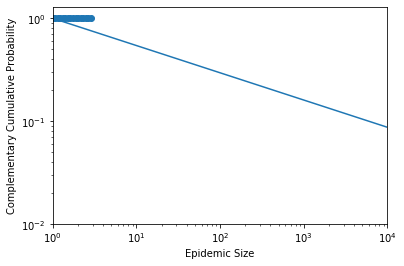

In [39]:
def RhodesPlot(EpiLengthList,MaxY=1.3,NumPoints=100):
    MinY = 0.01
    MaxY = 1.3
    MinX = 1
    MaxX = 10000
    ScalingExponent = 2.265
    NumEpidemics = len(EpiLengthList)
    x_EpiSizes = np.logspace(0,3,NumPoints)
    y_Probabilities = []
    for i, CompariSize in enumerate(x_EpiSizes):    
        Probability = 0
        for j, EpiSize in enumerate(EpiLengthList):
            if CompariSize <= EpiSize:                  
                Probability += 1
                continue
        if NumEpidemics is 0:
            print("ERROR: No epidemics concluded in this simulation")
        Probability = Probability/NumEpidemics
        y_Probabilities.append(Probability)

    #Plot the power law as a function of epidemic size used by Grassberger. = exp(-t + 2) (log-log scale, so the intercept will be (1,1))
    y_FitLine = [1**(-ScalingExponent + 2), MaxX**(-ScalingExponent + 2)]
    x_FitLine = [MinX,MaxX]
    
    plt.clf()
    plt.xlim(MinX,MaxX)
    plt.ylim(MinY,MaxY)
    plt.xlabel('Epidemic Size')
    plt.ylabel('Complementary Cumulative Probability')
    plt.xscale('log')
    plt.yscale('log')
    plt.scatter(x_EpiSizes, y_Probabilities)
    plt.plot(x_FitLine, y_FitLine)
    fig1 = plt.gcf()
    plt.show()
    if Save:
        fig1.savefig(SaveName)    
        print('Saved plot as', SaveName)

RhodesPlot([3])

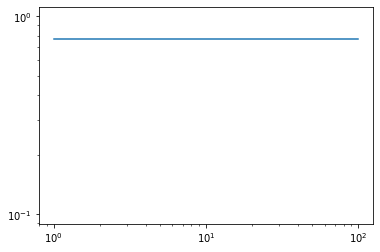

In [34]:
plt.xscale('log')
plt.yscale('log')
plt.plot([1,100], [np.exp(-2.265+2), np.exp(-2.265+2)])
plt.show()

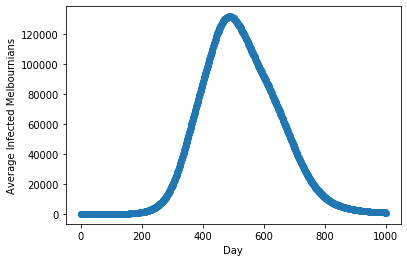

In [9]:
Save = False
InfectedPlot(AverageInfected)

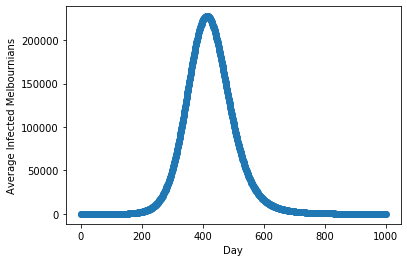

In [7]:
Save = False
InfectedPlot(AverageInfected)

In [47]:
a = 'Infected-Days'
a is 'Infected-Days'

True

In [27]:
np.linspace(1,10,10)

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

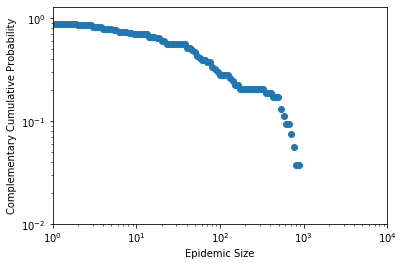

In [24]:
EpidemicLengthCombined = [183, 31, 6, 25, 808, 17, 529, 28, 55, 79, 16, 352, 33, 19, 161, 616, 107, 744, 89, 15, 555, 20, 61, 89, 49, 674, 13, 17, 886, 6, 66, 63, 10, 14, 425, 8, 25, 14, 6, 72, 150, 59, 919, 101, 50, 30, 540, 34, 137, 93, 15, 8, 50]

for i, Value in enumerate(EpidemicLengthCombined):
    if Value >= TimeIncubating:
        NewValue = Value - TimeIncubating
    else:
        NewValue = 0
    EpidemicLengthCombined[i] = NewValue
    
def RhodesPlot(EpiLengthList,MaxY=1.3,NumPoints=100):
    MaxY = 1.3
    NumEpidemics = len(EpiLengthList)
    x_EpiSizes = np.logspace(0,3,NumPoints)
    y_Probabilities = []
    for i, CompariSize in enumerate(x_EpiSizes):    
        Probability = 0
        for j, EpiSize in enumerate(EpiLengthList):
            if CompariSize <= EpiSize:                  
                Probability += 1
                continue
        Probability = Probability/NumEpidemics
        y_Probabilities.append(Probability)

    plt.clf()
    plt.xlim(1,10000)
    plt.ylim(0.01,MaxY)
    plt.xlabel('Epidemic Size')
    plt.ylabel('Complementary Cumulative Probability')
    plt.xscale('log')
    plt.yscale('log')
    plt.scatter(x_EpiSizes, y_Probabilities)
    plt.show()
        
RhodesPlot(EpidemicLengthCombined)

In [20]:
print(EpidemicLengthCombined)
EpidemicLengthCombinedBig = [183, 31, 6, 25, 808, 17, 529, 28, 55, 79, 16, 352, 33, 19, 161, 616, 107, 744, 89, 15, 555, 20, 61, 89, 49, 674, 13, 17, 886, 6, 66, 63, 10, 14, 425, 8, 25, 14, 6, 72, 150, 59, 919, 101, 50, 30, 540, 34, 137, 93, 15, 8, 50]

[183, 31, 6, 25, 808, 17, 529, 28, 55, 79, 16, 352, 33, 19, 161, 616, 107, 744, 89, 15, 555, 20, 61, 89, 49, 674, 13, 17, 886, 6, 66, 63, 10, 14, 425, 8, 25, 14, 6, 72, 150, 59, 919, 101, 50, 30, 540, 34, 137, 93, 15, 8, 50]


In [45]:
a = "Hello"
b = 'Hello'
"Hello" is b

True

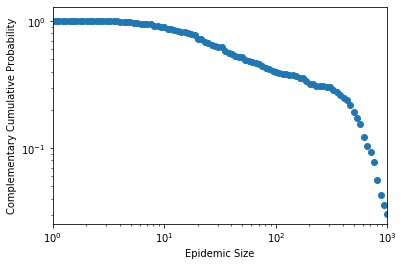

In [52]:
#Changing to same form as C.G.Rhodes Fig. 2(b)

def RhodesPlot(EpiLengthList,MaxY=1.3,NumPoints=100,):
    MaxY = 1.3
    NumEpidemics = len(EpiLengthList)
    x_EpiSizes = np.logspace(0,3,NumPoints)
    y_Probabilities = []
    for i, CompariSize in enumerate(x_EpiSizes):    
        Probability = 0
        for j, EpiSize in enumerate(EpiLengthList):
            if CompariSize <= EpiSize:                  
                Probability += 1
                continue
        Probability = Probability/NumEpidemics
        y_Probabilities.append(Probability)

    if AnimationSetting is False:
        plt.clf()
        plt.xlim(1,1000)
        plt.ylim(10/NumEpidemics,MaxY)
        plt.xlabel('Epidemic Size')
        plt.ylabel('Complementary Cumulative Probability')
        plt.xscale('log')
        plt.yscale('log')
        plt.scatter(x_EpiSizes, y_Probabilities)
        plt.show()
RhodesPlot(EpidemicLengthCombined)

In [51]:
print(EpidemicLengthCombined)

[196, 29, 9, 836, 20, 779, 16, 937, 13, 15, 453, 15, 35, 10, 638, 710, 8, 601, 13, 36, 12, 28, 4, 458, 155, 841, 622, 20, 55, 17, 33, 732, 55, 123, 20, 1995, 881, 363, 52, 797, 36, 93, 196, 27, 37, 18, 14, 374, 381, 637, 15, 3, 435, 35, 40, 579, 200, 43, 774, 34, 629, 13, 449, 387, 33, 4, 23, 612, 17, 744, 45, 8, 186, 316, 22, 641, 355, 4, 10, 1018, 8, 554, 7, 25, 493, 835, 18, 1045, 686, 29, 697, 10, 89, 23, 33, 35, 599, 43, 25, 716, 567, 82, 166, 47, 99, 27, 521, 525, 12, 14, 438, 16, 1290, 20, 5, 7, 8, 436, 125, 23, 1135, 19, 539, 472, 57, 20, 22, 48, 1048, 60, 259, 8, 24, 554, 35, 33, 5, 326, 15, 75, 218, 5, 192, 334, 56, 357, 36, 8, 18, 24, 432, 10, 24, 359, 11, 26, 65, 19, 435, 44, 103, 12, 90, 763, 20, 95, 21, 601, 34, 33, 190, 552, 185, 477, 39, 102, 795, 35, 19, 149, 8, 765, 482, 17, 13, 176, 25, 53, 8, 10, 46, 290, 43, 576, 1055, 10, 16, 8, 72, 410, 217, 20, 494, 55, 71, 25, 504, 11, 51, 22, 70, 495, 112, 5, 227, 4, 12, 514, 22, 177, 545, 22, 17, 69, 1116, 23, 97, 30, 439, 12

[196, 29, 9, 836, 20, 779, 16, 937, 13, 15, 453, 15, 35, 10, 638, 710, 8, 601, 13, 36, 12, 28, 4, 458, 155, 841, 622, 20, 55, 17, 33, 732, 55, 123, 20, 1995, 881, 363, 52, 797, 36, 93, 196, 27, 37, 18, 14, 374, 381, 637, 15, 3, 435, 35, 40, 579, 200, 43, 774, 34, 629, 13, 449, 387, 33, 4, 23, 612, 17, 744, 45, 8, 186, 316, 22, 641, 355, 4, 10, 1018, 8, 554, 7, 25, 493, 835, 18, 1045, 686, 29, 697, 10, 89, 23, 33, 35, 599, 43, 25, 716, 567, 82, 166, 47, 99, 27, 521, 525, 12, 14, 438, 16, 1290, 20, 5, 7, 8, 436, 125, 23, 1135, 19, 539, 472, 57, 20, 22, 48, 1048, 60, 259, 8, 24, 554, 35, 33, 5, 326, 15, 75, 218, 5, 192, 334, 56, 357, 36, 8, 18, 24, 432, 10, 24, 359, 11, 26, 65, 19, 435, 44, 103, 12, 90, 763, 20, 95, 21, 601, 34, 33, 190, 552, 185, 477, 39, 102, 795, 35, 19, 149, 8, 765, 482, 17, 13, 176, 25, 53, 8, 10, 46, 290, 43, 576, 1055, 10, 16, 8, 72, 410, 217, 20, 494, 55, 71, 25, 504, 11, 51, 22, 70, 495, 112, 5, 227, 4, 12, 514, 22, 177, 545, 22, 17, 69, 1116, 23, 97, 30, 439, 12

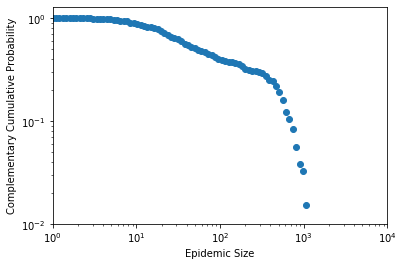

In [50]:
#Changing to same form as C.G.Rhodes Fig. 2(b)


print(EpidemicLengthCombined)
#Plot the frequency of epidemic lengths. We sort each epidemic length into a bin of size BinMultiple.
MaxY = 1.3
EpiLengthList = EpidemicLengthCombined
NumEpidemics = len(EpiLengthList)
NumPoints = 100
x_EpiSizes = np.logspace(0,4,NumPoints)
y_Probabilities = []
for i, CompariSize in enumerate(x_EpiSizes):    
    Probability = 0
    for j, EpiSize in enumerate(EpiLengthList):
        if CompariSize <= EpiSize:                  
            Probability += 1
            continue
    Probability = Probability/NumEpidemics
    y_Probabilities.append(Probability)
    
if AnimationSetting is False:
    plt.clf()
    plt.xlim(1,10000)
    plt.ylim(0.01,MaxY)
    plt.xlabel('Epidemic Size')
    plt.ylabel('Complementary Cumulative Probability')
    plt.xscale('log')
    plt.yscale('log')
    plt.scatter(x_EpiSizes, y_Probabilities)
    plt.show()

In [285]:
print(EpidemicLengthCombined)

[211, 30, 31, 13, 401, 61, 19, 18, 15, 429, 89, 82, 12, 30, 3, 286, 15, 70, 554, 1072, 5, 55, 6, 588, 22, 14, 520, 1627, 24, 1105, 7, 853, 36, 21, 733, 100, 13, 9, 6, 4, 9, 365, 53, 980, 178, 13, 38, 952, 114, 50, 5, 6, 629, 5, 831, 59, 1071, 129, 40, 365, 537, 3, 52, 10, 26, 303, 18, 22, 131, 1063, 287, 64, 868, 10, 488, 20, 57, 47, 754, 239, 22, 29, 4, 20, 25, 6, 302, 31, 70, 39, 610, 7, 21, 415, 36, 8, 1121, 40, 534, 71, 25, 33, 720, 72, 554, 15, 11, 104, 678, 4, 77, 670, 16, 177, 29, 10, 686, 10, 6, 80, 496, 10, 813, 17]


In [1]:
EpidemicLengthFirstThreeRuns = [211, 30, 31, 13, 401, 61, 19, 18, 15, 429, 89, 82, 12, 30, 3, 286, 15, 70, 554, 1072, 5, 55, 6, 588, 22, 14, 520, 1627, 24, 1105, 7, 853, 36, 21, 733, 100, 13, 9, 6, 4, 9, 365, 53, 980, 178, 13, 38, 952, 114, 50, 5, 6, 629, 5, 831, 59, 1071, 129, 40, 365, 537, 3, 52, 10, 26, 303, 18, 22, 131, 1063, 287, 64, 868, 10, 488, 20, 57, 47, 754, 239, 22, 29, 4, 20, 25, 6, 302, 31, 70, 39, 610, 7, 21, 415, 36, 8, 1121, 40, 534, 71, 25, 33, 720, 72, 554, 15, 11, 104, 678, 4, 77, 670, 16, 177, 29, 10, 686, 10, 6, 80, 496, 10, 813, 17]

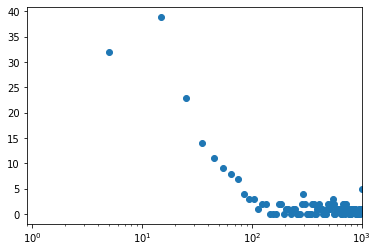

In [83]:
#Plot the frequency of epidemic lengths. We sort each epidemic length into a bin of size BinMultiple.
import matplotlib.pyplot as plt
EpiLengthList = EpidemicLengthFirstThreeRuns 
BinsList = []
FrequencyList = []
BinMultiple = 10
NumBins = 100
LastBin = 0
for i in range(NumBins):
    BinsList.append((i+0.5)*BinMultiple)    
for i in range(NumBins):    
    Frequency = 0
    for j, value in enumerate(EpiLengthList):
        if i != 0:
            LastBin = BinsList[i-1]
        if i != NumBins - 1:
            NextBin = BinsList[i+1]
        else:
            NextBin += 0.5*BinMultiple
        if LastBin < value <= NextBin:                  #Note that we won't capture anything greater than a certain limit!
            Frequency += 1
            continue
    FrequencyList.append(Frequency)

plt.clf()
plt.xlim(0.9,1000)
plt.xscale('log')
plt.scatter(BinsList, FrequencyList)
plt.show()

In [ ]:
#Plot the frequency of epidemic lengths. We sort each epidemic length into a bin of size BinMultiple.
import matplotlib.pyplot as plt
EpiLengthList = EpidemicLengthFirstThreeRuns 
BinsList = []
FrequencyList = []
BinMultiple = 10
NumBins = 100
LastBin = 0
for i in range(NumBins):
    BinsList.append((i+0.5)*BinMultiple)    
for i in range(NumBins):    
    Frequency = 0
    for j, value in enumerate(EpiLengthList):
        if i != 0:
            LastBin = BinsList[i-1]
        if i != NumBins - 1:
            NextBin = BinsList[i+1]
        else:
            NextBin += 0.5*BinMultiple
        if LastBin < value <= NextBin:                  #Note that we won't capture anything greater than a certain limit!
            Frequency += 1
            continue
    FrequencyList.append(Frequency)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_xscale('log')
ax.scatter(BinsList, FrequencyList)
plt.show()

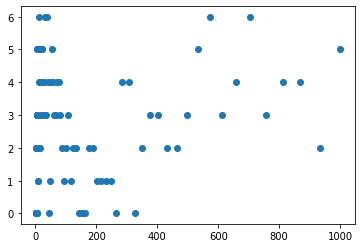

In [52]:
#LOG PLOT VERSION
import numpy as np
import matplotlib.pyplot as plt



#Plot the frequency of epidemic lengths. We sort each epidemic length into a bin of size BinMultiple.
import matplotlib.pyplot as plt
EpiLengthList = EpidemicLengthFirstThreeRuns 
FrequencyList = []
BinsList = np.logspace(0,3.03030303,101)
for i in range(NumBins):    
    Frequency = 0
    for j, value in enumerate(EpiLengthList):
        if i != 0:
            LastBin = BinsList[i-1]
        else:
            LastBin = 0
        NextBin = BinsList[i+1]
        if LastBin < value <= NextBin:                  #Note that we won't capture anything greater than a certain limit!
            Frequency += 1
            continue
    FrequencyList.append(Frequency)

plt.clf()
plt.scatter(BinsList[:-1], FrequencyList)
plt.show()

In [48]:
BinsList = np.logspace(0,3.03030303,101)
BinsList[:-1]

array([  1.        ,   1.07226722,   1.149757  ,   1.23284674,
         1.32194115,   1.41747416,   1.51991108,   1.62975083,
         1.7475284 ,   1.87381742,   2.009233  ,   2.15443469,
         2.3101297 ,   2.47707636,   2.65608778,   2.84803587,
         3.05385551,   3.27454916,   3.51119173,   3.76493581,
         4.03701726,   4.32876128,   4.64158883,   4.97702356,
         5.33669923,   5.72236766,   6.13590727,   6.57933225,
         7.05480231,   7.56463327,   8.11130831,   8.69749002,
         9.32603347,  10.        ,  10.72267222,  11.49756995,
        12.32846739,  13.21941148,  14.17474163,  15.19911083,
        16.29750834,  17.475284  ,  18.73817422,  20.09233002,
        21.54434689,  23.10129699,  24.77076355,  26.56087782,
        28.48035867,  30.53855508,  32.74549162,  35.11191733,
        37.64935805,  40.37017257,  43.28761279,  46.41588832,
        49.77023562,  53.36699229,  57.22367657,  61.35907271,
        65.79332244,  70.54802308,  75.64633272,  81.11

In [91]:
Chance = np.random.random_sample()
print(Chance)
print(Chance)

0.3123176776258534
0.3123176776258534


In [229]:
print(HealthyBank2)

12.0


Current bugs known:
1. Number of frames genned as a percentage of epidemic days does not match AnimationSetting against frames.  (minor) Update: Fixed I think
2. Mismatch by 1 individual between population total tracked and the sum of the cells. (minor)

In [125]:

UpdateSpaceArray = np.empty((1, 1), dtype='object')
UpdateSpaceArray[0,0] = Sample6x6InfectedGrid

print(SampleGridArray)

[]


In [108]:
SampleGridArray = np.array([[Sample6x6GridHealthy,Sample6x6InfectedGrid,Sample3x3IslandGrid],[Sample2x2IslandGrid,EmptyRegion,Sample4x4IslandPopulated],[EmptyRegion,EmptyRegion,Sample2x2IslandGrid]],dtype='O')
print(SampleGridArray)

[[array([[[  300.,     0.,     0.,     0.,     0.],
        [  300.,     0.,     0.,     0.,     0.],
        [  300.,     0.,     0.,     0.,     0.],
        [  300.,     0.,     0.,     0.,     0.],
        [  300.,     0.,     0.,     0.,     0.],
        [  300.,     0.,     0.,     0.,     0.]],

       [[  180.,     0.,     0.,     0.,     0.],
        [  300.,     0.,     0.,     0.,     0.],
        [  300.,     0.,     0.,     0.,     0.],
        [  300.,     0.,     0.,     0.,     0.],
        [  300.,     0.,     0.,     0.,     0.],
        [  300.,     0.,     0.,     0.,     0.]],

       [[  300.,     0.,     0.,     0.,     0.],
        [50000.,     0.,     0.,     0.,     0.],
        [  300.,     0.,     0.,     0.,     0.],
        [  300.,     0.,     0.,     0.,     0.],
        [   70.,     0.,     0.,     0.,     0.],
        [   40.,     0.,     0.,     0.,     0.]],

       [[  190.,     0.,     0.,     0.,     0.],
        [  300.,     0.,     0.,     0.,  

In [7]:
a = False
if a is not True:
    print("sasd")

sasd


In [264]:
a = [2,56]
b = [2,3]
b += a
print(b)

[2, 3, 2, 56]


In [4]:
BirthCoord = [3,2,1]
x, y, z = BirthCoord
print(y)

2


In [60]:
print(Map)

[[[59520.     0.     0.     0.     0.]
  [59520.    10.     0.     0.     0.]
  [  430.     0.     0.     0.     0.]]

 [[  180.     0.     0.     0.     0.]
  [    0.     0.     0.     0.     0.]
  [ 1410.     0.     0.     0.     0.]]

 [[    0.     0.     0.     0.     0.]
  [    0.     0.     0.     0.     0.]
  [  180.     0.     0.     0.     0.]]]


In [71]:
beetle = [42,3]
def a():
    beetle[0]+=3
    print(beetle)
print(beetle)
a()

[42, 3]
[45, 3]


In [57]:
beetle = 42
def a():
    fur = 10
    def b():
        global beetle
        if np.all(beetle)== True:
            print("Done")
        beetle += 2
        capy = beetle * fur
        return capy
    def c():
        happycapy = beetle*fur**2
        return happycapy
    capy = 1
    babycapy = b()+c()
    return babycapy

print(a())

Done
4840


ax_1
ax_2
ax_3
ax_4


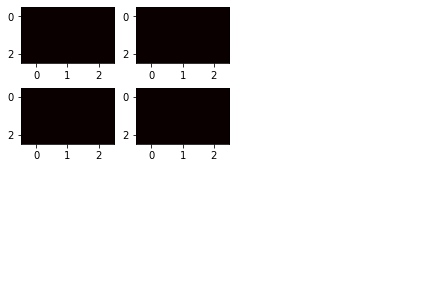

In [45]:
#globals()[AxDict[XM*XMapLength+YM+1]] = fig.add_subplot(spec[XPlot, YPlot])   

XMapLength = 2
YMapLength = 2

fig = plt.figure(constrained_layout=True)
spec = fig.add_gridspec(4, 4)

AxDict={}
for n in range(XMapLength*YMapLength):
    AxDict[n+1] = "ax_"+str(n+1)

for XM in range(XMapLength):
    for YM in range(YMapLength):
        XPlot = XM
        YPlot = YM
        print(AxDict[XM*XMapLength+YM+1])
        globals()[AxDict[XM*XMapLength+YM+1]] = fig.add_subplot(spec[XPlot, YPlot])
        dothing()

def dothing():
    ax_spec = globals()[AxDict[XPlot*XMapLength+YPlot+1]]
    BlankGrid = np.zeros((3,3))
    ax_spec.imshow(BlankGrid, cmap='hot', interpolation='none', aspect='auto') #Single: plt.imshow(BlankGrid, cmap='binary', interpolation='none')
    #globals()[AxDict[XPlot*XMapLength+YPlot+1]] = ax_spec
dothing()

Text(0.5, 1.0, 'gs[-1, -2]')

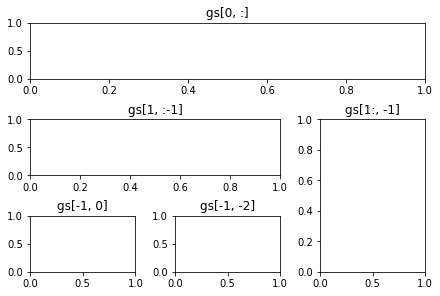

In [104]:
fig3 = plt.figure(constrained_layout=True)
gs = fig3.add_gridspec(3, 3)
f3_ax1 = fig3.add_subplot(gs[0, :])
f3_ax1.set_title('gs[0, :]')
f3_ax2 = fig3.add_subplot(gs[1, :-1])
f3_ax2.set_title('gs[1, :-1]')
f3_ax3 = fig3.add_subplot(gs[1:, -1])
f3_ax3.set_title('gs[1:, -1]')
f3_ax4 = fig3.add_subplot(gs[-1, 0])
f3_ax4.set_title('gs[-1, 0]')
f3_ax5 = fig3.add_subplot(gs[-1, -2])
f3_ax5.set_title('gs[-1, -2]')

Text(0.5, 1.0, 'D')

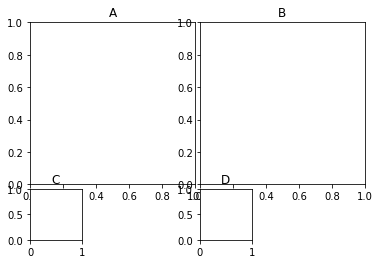

In [142]:

fig3 = plt.figure(constrained_layout=False)
gs = fig3.add_gridspec(8, 12)
f3_ax1 = fig3.add_subplot(gs[0:6, 0:6])
f3_ax1.set_title('A')


f3_ax2 = fig3.add_subplot(gs[0:6, 6:12])
f3_ax2.set_title('B')

f3_ax3 = fig3.add_subplot(gs[6:8, 0:2])
f3_ax3.set_title('C')

f3_ax4 = fig3.add_subplot(gs[6:8, 6:8])
f3_ax4.set_title('D')


In [ ]:

'''
f3_ax3 = fig3.add_subplot(gs[2, 2])
f3_ax3.set_title('C')

f3_ax4 = fig3.add_subplot(gs[3, 3])
f3_ax4.set_title('D')

f3_ax5 = fig3.add_subplot(gs[4, 4])
f3_ax5.set_title('E')'''


In [90]:
a =[0,3,2,1]
print(a[0:1])

[0]


In [8]:
exit()

In [66]:
#input String
str = "Pythonpool"
 
#apply exec() method
exec("%s = %d" % (str,5000))
 
#print string
print("output : ",Pythonpool) 

output :  5000


In [71]:
#taking input as a string
str = "pythonpool"

locals()[str] = 5000
print(pythonpool)

5000


In [53]:
globals()["var_"+str(0)]=3
print(var_0)

SyntaxError: can't assign to operator (<ipython-input-53-db65ce95e43c>, line 1)

In [49]:
"ax_"+str(3)

'ax_3'

Other TODO:

    -Make Incubation to Infection algorithm better
    -Plot map and not regions, but with say 16 regions. Also make regional travel significantly less likely. :::::::DONE
    -Make Reff change relative how healthy its potential targets are. With the logic being that we are assuming people will be in contact with roughly the same number of people regardless how dense their area is. :::::::DONE
    -Figure out why getting negative infected. :::::::Partially Done

In [112]:
print(HealthyBank) # before implementing HealthyBank2

12814.0


In [131]:
print(HealthyBank,HealthyBank2)

2500.0 6638.0


In [12]:
a = np.array([2,3], [4,5])
coord = (3,2)
print(a[coord])

TypeError: data type not understood

In [19]:
a = np.array([[np.array([0,3]),[0]],[[0],[0]]])
print(a)

[[array([0, 3]) list([0])]
 [list([0]) list([0])]]
